# 14MBID - TFM

# El parque automovilístico de segunda mano en España. Análisis y estimación del precio de venta

## Manuel Campoy Naranjo

### Cuaderno 3

En este cuaderno se hace el análisis descriptivo, prueba y ajuste de modelos para el dataframe df_2mano

## Importación de paquetes y librerías. Configuración de rutas y figuras

In [1]:
!pip install jcopml --quiet
!pip install feature_selector --no-binary=:all: --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Running setup.py install for feature_selector ... done


In [2]:
import time
import os
import io
import pandas as pd
import numpy as np
from numpy import corrcoef, transpose, arange
import seaborn as sns
import plotly.express as px
from google.colab import drive
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib.animation import FuncAnimation

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

#ML

from sklearn import ensemble, preprocessing, metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from feature_selector import FeatureSelector 
from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_correlation_matrix
from jcopml.plot import plot_actual_vs_prediction, plot_residual
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE,chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.linear_model import Lasso, SGDClassifier, LassoCV, MultiTaskLassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample,shuffle

In [3]:
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/TFM/Datasets"

 accidentes.xlsx		    'ventas marca 2019.xlsx'
 autocasion2mano.xlsx		    'ventas marca 2020.xlsx'
 autocasionnuevos.xlsx		    'ventas marca 2021.xlsx'
 coches-de-segunda-mano-sample.csv  'ventas marca 2022.xlsx'
 cochesnetnuevos.xlsx		    'ventas modelo 2015.xlsx'
 datosBI.xlsx			    'ventas modelo 2016.xlsx'
 df_2mano_dummies.xlsx		    'ventas modelo 2017.xlsx'
 df_2mano_pop_dummies.xlsx	    'ventas modelo 2018.xlsx'
 df_2mano_pop_pre_dummies.xlsx	    'ventas modelo 2019.xlsx'
 df_2mano_pop_pre.xlsx		    'ventas modelo 2020.xlsx'
 df_2mano_pop.xlsx		    'ventas modelo 2021.xlsx'
 df_2mano.xlsx			    'ventas modelo 2022.xlsx'
 df_provincias.xlsx		    'ventas provincia 2015.xlsx'
 parque.xlsx			    'ventas provincia 2016.xlsx'
 pib-capita.xlsx		    'ventas provincia 2017.xlsx'
 poblacion.xlsx			    'ventas provincia 2018.xlsx'
 transferencias.xlsx		    'ventas provincia 2019.xlsx'
'ventas marca 2015.xlsx'	    'ventas provincia 2020.xlsx'
'ventas marca 2016.xlsx'	    'ventas provincia 2

Se crea un path de acceso para más comodidad (tanto en local como en Drive)

In [5]:
#path = '/Users/mcamp/OneDrive/Escritorio/TFM/'
#path = '/Users/manolo/Documents/Personales/Estudios/Máster Big Data y Data Science/Asignaturas/14MBID - TFM/Datasets/'
path = '/content/drive/My Drive/TFM/Datasets/'

## Importación del dataframe


In [6]:
df_2mano = pd.read_excel(path+'df_2mano.xlsx', index_col=[0])

In [7]:
df_2mano.dtypes

Marca           object
Modelo          object
Precio           int64
Combustible     object
Año              int64
Kilometraje      int64
Potencia       float64
Cambio          object
Fotos            int64
Provincia       object
dtype: object

## Estadística descriptiva

### Variables numéricas

Realizamos un análisis descriptivo que nos permita ver si es necesario hacer algunas modificaciones adicionales en el dataframe a las ya realizadas durante el preprocesado y limpieza

In [8]:
df_2mano.describe()

,Precio,Año,Kilometraje,Potencia,Fotos
count,7.918800e+04,79188.000000,7.918800e+04,79188.000000,79188.000000
mean,2.516295e+04,2013.800563,1.035688e+05,156.512262,17.787480
std,1.140646e+05,6.648264,1.113897e+05,96.053652,12.551707
min,7.000000e+00,1970.000000,0.000000e+00,1.000000,0.000000
25%,7.500000e+03,2009.000000,2.430150e+04,110.000000,9.000000
50%,1.530000e+04,2016.000000,8.400000e+04,131.000000,15.000000
75%,2.490000e+04,2019.000000,1.570000e+05,170.000000,25.000000
max,1.208790e+07,2022.000000,8.067058e+06,3239.000000,212.000000


Se observa que el precio medio de venta es de unos 25000 euros. El año promedio es de sobre 2014, existen coches en venta matriculados en 1970.

(array([0]), <a list of 1 Text major ticklabel objects>)

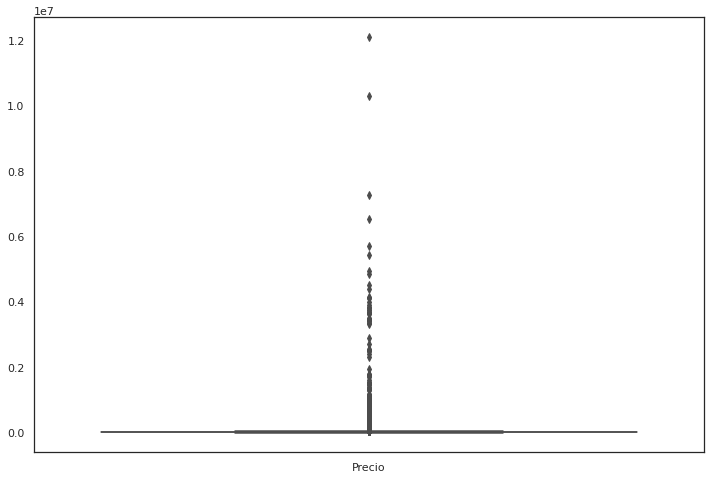

In [9]:
sns.set(style="white")
sns.boxplot(data=df_2mano[['Precio']])
plt.xticks(rotation=0)

Hay coches con un valor muy bajo (unos 100 euros) y otros excesivamente altos (el máximo está en más de 1e7).

Vamos a ver los coches que tiene una valor inferior a 300 euros

In [10]:
df_2mano.loc[df_2mano['Precio'] <= 300]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia
3778,CITROEN,XANTIA,300,Gasolina,1997,190000,90.0,Manual,0,Tarragona
5119,SEAT,IBIZA,300,Gasolina,2002,70000,100.0,Manual,9,Albacete
9174,FORD,MONDEO,300,Diesel,1996,246000,145.0,Manual,0,Salamanca
14049,OPEL,VECTRA,300,Gasolina,2003,90000,147.0,Manual,1,Barcelona
15962,FORD,ESCORT,300,Gasolina,1998,190000,105.0,Manual,0,Sta. Cruz Tenerife
17312,CITROEN,SAXO,300,Gasolina,1996,353335,60.0,Manual,0,Sta. Cruz Tenerife
21318,FORD,FIESTA,300,Diesel,1995,49000,82.0,Manual,0,Ávila
22912,OPEL,ASTRA,300,Diesel,2002,240000,110.0,Manual,0,Cádiz
23334,SEAT,CORDOBA,300,Gasolina,1998,200000,90.0,Manual,1,Sta. Cruz Tenerife
26252,VOLKSWAGEN,BEETLE,300,Gasolina,2000,100000,115.0,Manual,0,Balears (Illes)


Vamos a eliminar los coches que tienen un precio inferior a 300 euros, puesto que parece que son una errata

In [11]:
df_2mano = df_2mano.loc[(df_2mano['Precio'] >= 300)]

Vemos los coches que tienen un precio excesivamente alto

In [12]:
df_2mano.loc[df_2mano['Precio'] >= 200000]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia
197,PORSCHE,911,410000,Gasolina,2019,150,510.0,Manual,12,Girona
3761,MERCEDES-BENZ,CLASE G,358900,Gasolina,2019,4300,585.0,Automatico,19,Barcelona
4528,PORSCHE,911,389000,Gasolina,2018,15000,700.0,Automatico,22,Madrid
5555,MERCEDES-BENZ,CLASE G,322900,Gasolina,2020,200,585.0,Automatico,18,Barcelona
6023,FERRARI,812,305400,Gasolina,2019,24000,800.0,Automatico,13,Valencia
...,...,...,...,...,...,...,...,...,...,...
77407,MERCEDES-BENZ,CLASE G,229990,Gasolina,2019,40000,585.0,Automatico,30,Pontevedra
78009,MERCEDES-BENZ,CLASE G,224900,Gasolina,2018,35400,585.0,Automatico,39,Valencia
78376,FERRARI,488,234900,Gasolina,2016,18884,670.0,Automatico,21,Málaga
78499,FERRARI,488,254999,Gasolina,2017,14900,670.0,Automatico,26,Málaga


Vemos un histograma con la distribución de precios

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


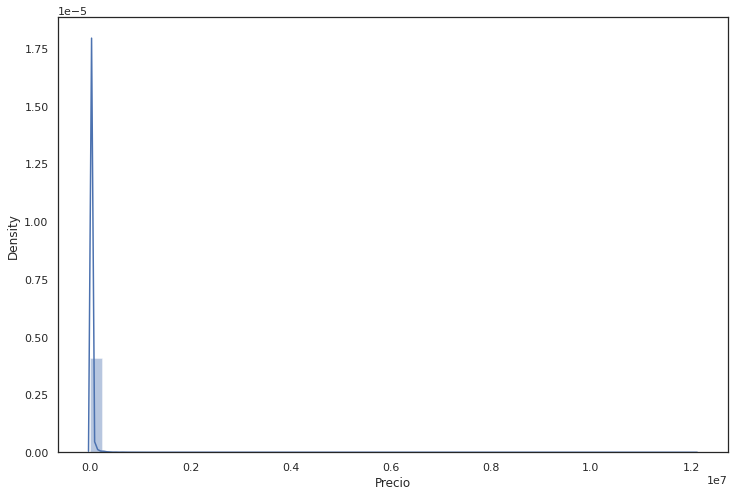

In [13]:
sns.distplot(df_2mano['Precio'])

Vemos que son coches de marcas premium y que apenas hay instancias con precios superiores a 200000 euros (sólo 772 instancias)

No son muchos instancias, pero seguramente van a hacer que nuestro modelo no sea excesivamente bueno prediciendo en el rango alto de valores.

Podríamos tomar la decisión de eliminar esas instancias, pero entonces nuestro modelo no recogería estas "anomalías". Tomamos la decisión de mantenerlas (al menos por el momento)

In [14]:
#skewness and kurtosis
print("Skewness: %f" % df_2mano['Precio'].skew())
print("Kurtosis: %f" % df_2mano['Precio'].kurt())

Skewness: 47.617662
Kurtosis: 3367.261183


Los valores muestran que la distribución es bastante asimétrica (con asimetría positiva) y con gran concentración de valores respecto a la media

(array([0]), <a list of 1 Text major ticklabel objects>)

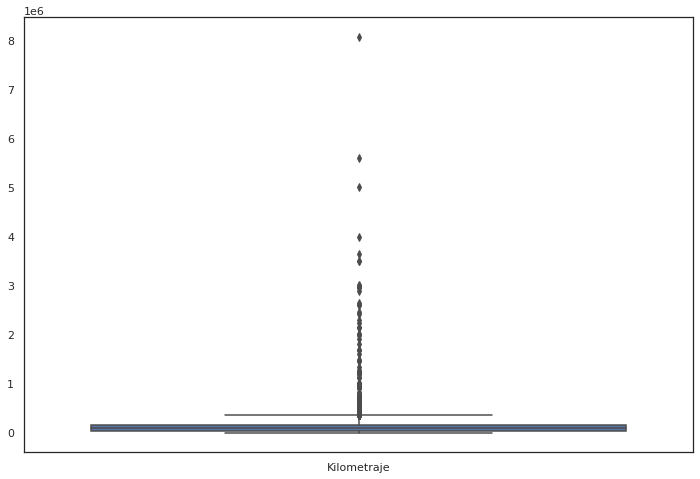

In [15]:
sns.set(style="white")
sns.boxplot(data=df_2mano[['Kilometraje']])
plt.xticks(rotation=0)

Hay coches que tienen un kilometraje excesivo. Vemos cuáles son

In [16]:
df_2mano.loc[df_2mano['Kilometraje'] >= 600000]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia
1337,CITROEN,C5,1200,Diesel,2007,2010000,131.0,Manual,4,Toledo
1973,MERCEDES-BENZ,300,3500,Gasolina,1990,2450000,231.0,Automatico,0,Ciudad Real
2811,MERCEDES-BENZ,CLASE E,7990,Diesel,2011,650000,170.0,Automatico,16,Málaga
3176,SEAT,TOLEDO,1700,Diesel,2002,3000000,110.0,Manual,8,Madrid
4434,SEAT,IBIZA,1800,Gasolina,2009,1134000,90.0,Manual,2,Navarra
...,...,...,...,...,...,...,...,...,...,...
59249,VOLKSWAGEN,GOLF,4500,Diesel,2009,605900,110.0,Manual,12,Lugo
59250,SKODA,SUPERB,8900,Diesel,2016,600000,150.0,Automatico,17,Málaga
59251,TOYOTA,PRIUS,3750,Hibrido,2010,600000,122.0,Automatico,0,Madrid
77010,MINI,MINI,19990,Gasolina,2019,1692814,102.0,Manual,24,Almería


Hay coches con más de un millón de kms. Podría ser cierto, pero parece complicado de creer (quizás sí si se tiene en cuenta la antigüedad de los mismos). Vamos a eliminar aquellos por encima del millón de kms.

In [17]:
df_2mano = df_2mano.loc[(df_2mano['Kilometraje'] <= 1e6)]

Vemos la distribución de Año de matriculación

(array([0]), <a list of 1 Text major ticklabel objects>)

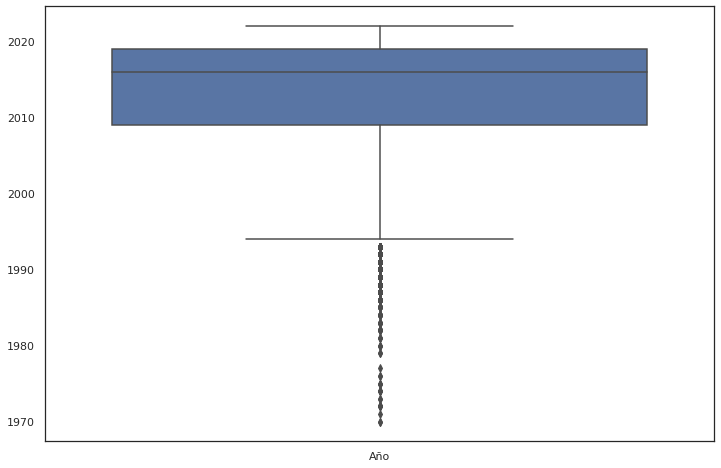

In [18]:
sns.set(style="white")
sns.boxplot(data=df_2mano[['Año']])
plt.xticks(rotation=0)

Se observa que hay algunos registros con bastante antigüedad. Podríamos tomar la decisión de eliminar los que tienen una antigüedad muy importante (e.g., matriculaciones anteriores a 1990), pero en un principio dejamos todos

Vemos ahora la distribución de potencia y del número de fotos del anuncio

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

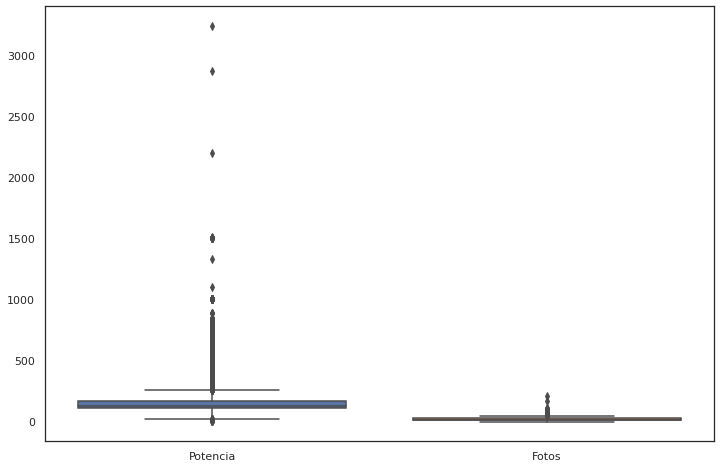

In [19]:
sns.set(style="white")
sns.boxplot(data=df_2mano[['Potencia', 'Fotos']])
plt.xticks(rotation=0)

Hay algunos vehículos con potencias muy altas y otros con potencia demasiado bajas. Vamos a verlo

In [20]:
df_2mano.loc[df_2mano['Potencia'] <= 40]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia
4858,RENAULT,R4,600,Gasolina,1996,100000,38.0,Manual,5,Málaga
5658,INVICTA,D2S,21495,Electrico,2021,3,37.0,Automatico,16,Burgos
6625,RENAULT,R4,2700,Gasolina,1993,145,38.0,Manual,9,Jaén
8665,RENAULT,R4,3000,Gasolina,1984,100000,38.0,Manual,4,Murcia
10635,RENAULT,R4,4200,Gasolina,1990,64075,38.0,Manual,9,Murcia
11430,RENAULT,R4,4500,Gasolina,1982,68000,40.0,Manual,13,Málaga
18749,CITROEN,2CV,7000,Gasolina,1982,75000,29.0,Manual,14,Madrid
21751,CITROEN,2CV,5000,Gasolina,1982,73500,29.0,Manual,7,Valladolid
24056,RENAULT,R4,1200,Gasolina,1987,100000,38.0,Manual,0,Cáceres
35868,SEAT,MARBELLA,3000,Gasolina,1989,13000,40.0,Manual,1,Córdoba


In [21]:
df_2mano.loc[df_2mano['Potencia'] >= 900]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia
50146,JAGUAR,XJS,3900,Gasolina,1996,122001,3239.0,Manual,4,Sevilla
50156,FERRARI,SF90,615000,Hibrido,2020,50,1000.0,Automatico,1,Murcia
52283,MERCEDES-BENZ,CLASE V,29900,Diesel,1998,90312,2874.0,Manual,7,Palmas (Las)
54678,BUGATTI,CHIRON,12087900,Gasolina,2021,50,1500.0,Automatico,1,Murcia
54679,BUGATTI,CHIRON,4950000,Gasolina,2021,80,1500.0,Automatico,1,Murcia
54682,BUGATTI,CHIRON,4850000,Gasolina,2021,5100,1500.0,Automatico,1,Murcia
54684,BUGATTI,VEYRON,3650000,Gasolina,2015,4500,1500.0,Automatico,2,Murcia
54690,FERRARI,SF90,679000,Hibrido,2021,500,1000.0,Automatico,20,Murcia
54691,FERRARI,SF90,649000,Hibrido,2021,7400,1000.0,Automatico,8,Murcia
54692,FERRARI,SF90,645000,Hibrido,2021,7500,1000.0,Automatico,8,Murcia


Se observa que hay errores en los valores de potencia inferiores a 20 CV. También consideramos que los valores superiores a más de 1500 CV son un error. Igualmente, la instancia 62412 es un error (se elimina)

In [22]:
df_2mano = df_2mano.loc[(df_2mano['Potencia'] >= 20)]
df_2mano = df_2mano.loc[(df_2mano['Potencia'] <= 1500)]
df_2mano.drop(df_2mano.iloc[62348].name, inplace = True)

Respecto de las fotografías, es razonable que haya una gran variabilidad, aunque aquellos casos en los que se disponen de más de 100 fotos parecen excesivos. En cualquier caso, esta característica está por ver si aporta algo o no.

In [23]:
df_2mano.reset_index(inplace = True, drop = True)

In [24]:
df_2mano.describe()

,Precio,Año,Kilometraje,Potencia,Fotos
count,7.910700e+04,79107.000000,79107.000000,79107.000000,79107.000000
mean,2.512632e+04,2013.804252,102210.487340,156.439544,17.796832
std,1.133438e+05,6.645357,91177.345593,94.541680,12.551117
min,3.000000e+02,1970.000000,0.000000,20.000000,0.000000
25%,7.500000e+03,2009.000000,24294.500000,110.000000,9.000000
50%,1.530000e+04,2016.000000,84000.000000,131.000000,15.000000
75%,2.490000e+04,2019.000000,156900.000000,170.000000,25.000000
max,1.208790e+07,2022.000000,999999.000000,1500.000000,212.000000


Podemos ver también la correlación que hay entre las variables numéricas (excluyendo la variable objetivo, que es la que precisamente queremos correlacionar).

Para esto, nos quedamos sólo con las variables numéricas y quitamos la columna 'Precio'

In [25]:
df_2mano_num = df_2mano.select_dtypes(include=[np.number])
df_2mano_num = transpose(df_2mano_num.drop(['Precio'], axis = 1))
nombres_num = df_2mano_num.index

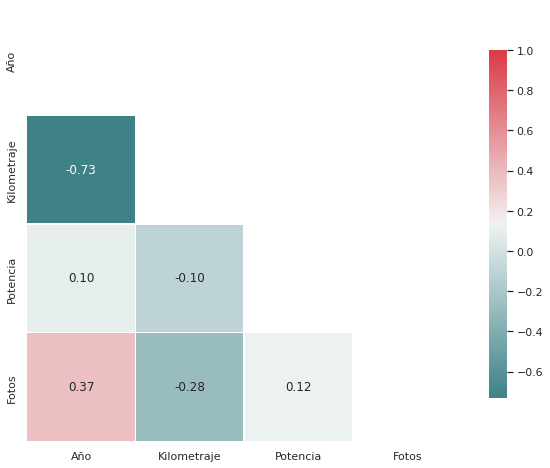

In [26]:
R = corrcoef(df_2mano_num)
sns.set(style="white")
mask = np.zeros_like(R, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=nombres_num, yticklabels=nombres_num, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

Se observa que hay una correlación moderada entre los kilometros y el año (algo que tiene sentido, ya que mientras más nuevo sea el coche, menos kilómetros suele haber recorrido). Decidimos no quitar ninguna de las variables

Si se analiza la correlación incluyendo el precio de venta (variable objetivo)

In [27]:
df_2mano_num = df_2mano.select_dtypes(include=[np.number])
df_2mano_num = transpose(df_2mano_num)
nombres_num = df_2mano_num.index

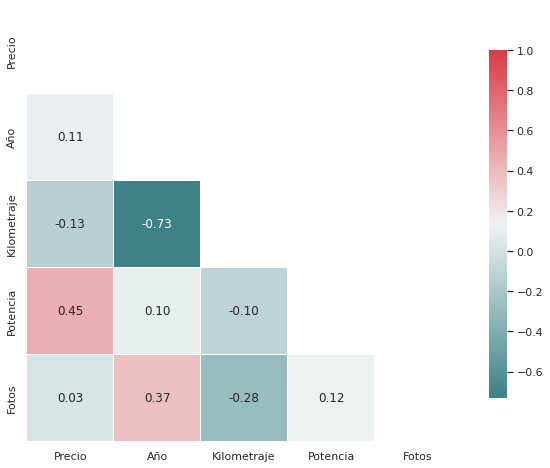

In [28]:
R = corrcoef(df_2mano_num)
sns.set(style="white")
mask = np.zeros_like(R, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=nombres_num, yticklabels=nombres_num, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

### Variables categóricas

En el dataframe existen variables que son de tipo categórico, como son la marca, el modelo, o la provincia.

Verificamos en primer lugar el número de categorías que tenemos en cada una de las variables de este tipo

In [29]:
df_2mano_cat = df_2mano.select_dtypes(exclude=[np.number])
cat_cols = df_2mano_cat.columns.values
df_2mano_cat.nunique(axis=0)

Marca           90
Modelo         972
Combustible      6
Cambio           2
Provincia       52
dtype: int64

Vemos que hay muchas categorías en algunas de las variables, como es el caso de Modelo (972 categorías)

Vamos a ver la distribución de categorías en la variable Marca, ya que tiene un número más o menos manejable

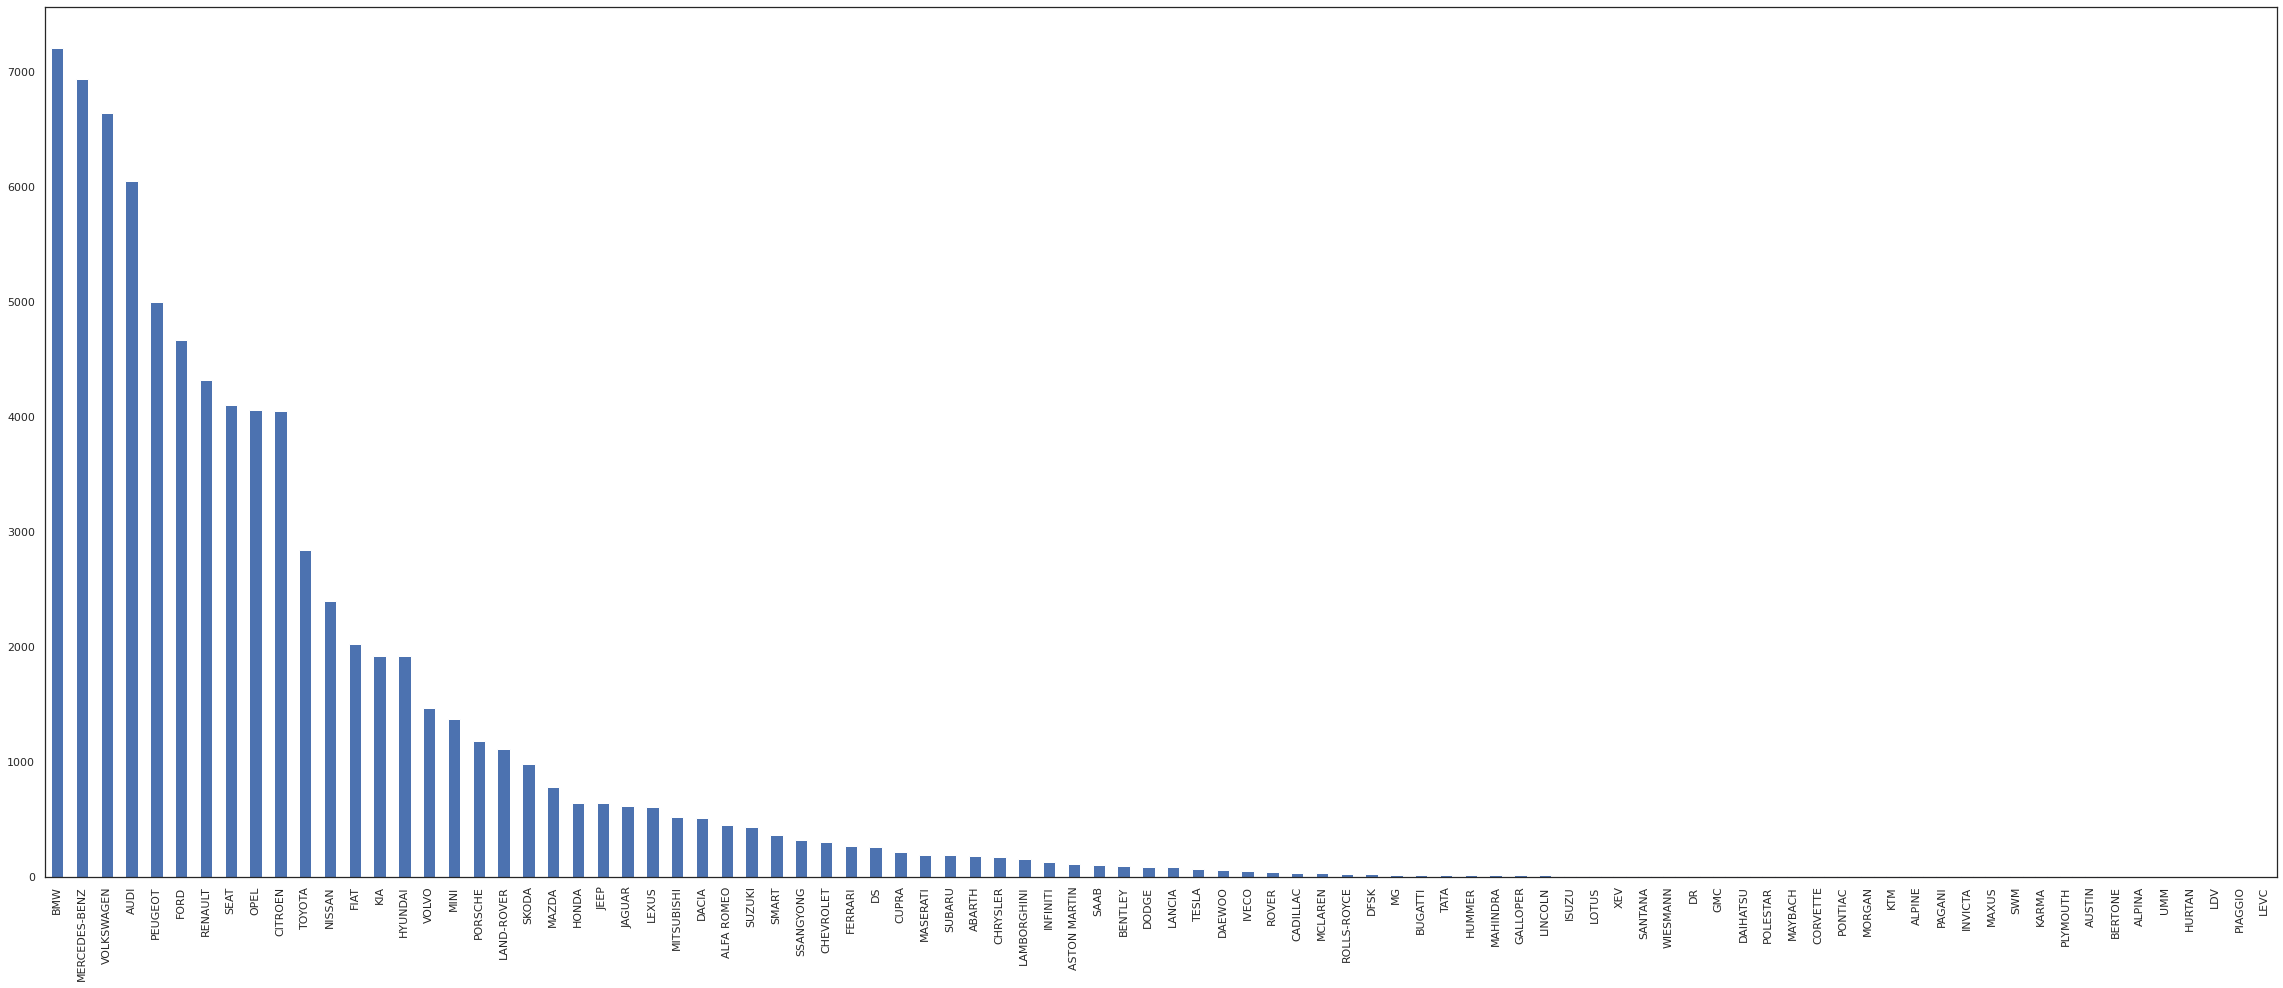

In [30]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(40, 16))
df_2mano['Marca'].value_counts().plot.bar()

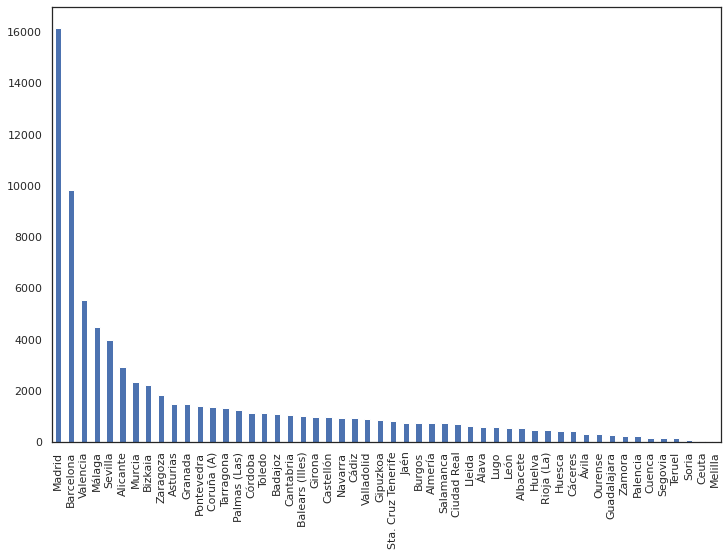

In [31]:
sns.set(style="white")
df_2mano['Provincia'].value_counts().plot.bar()

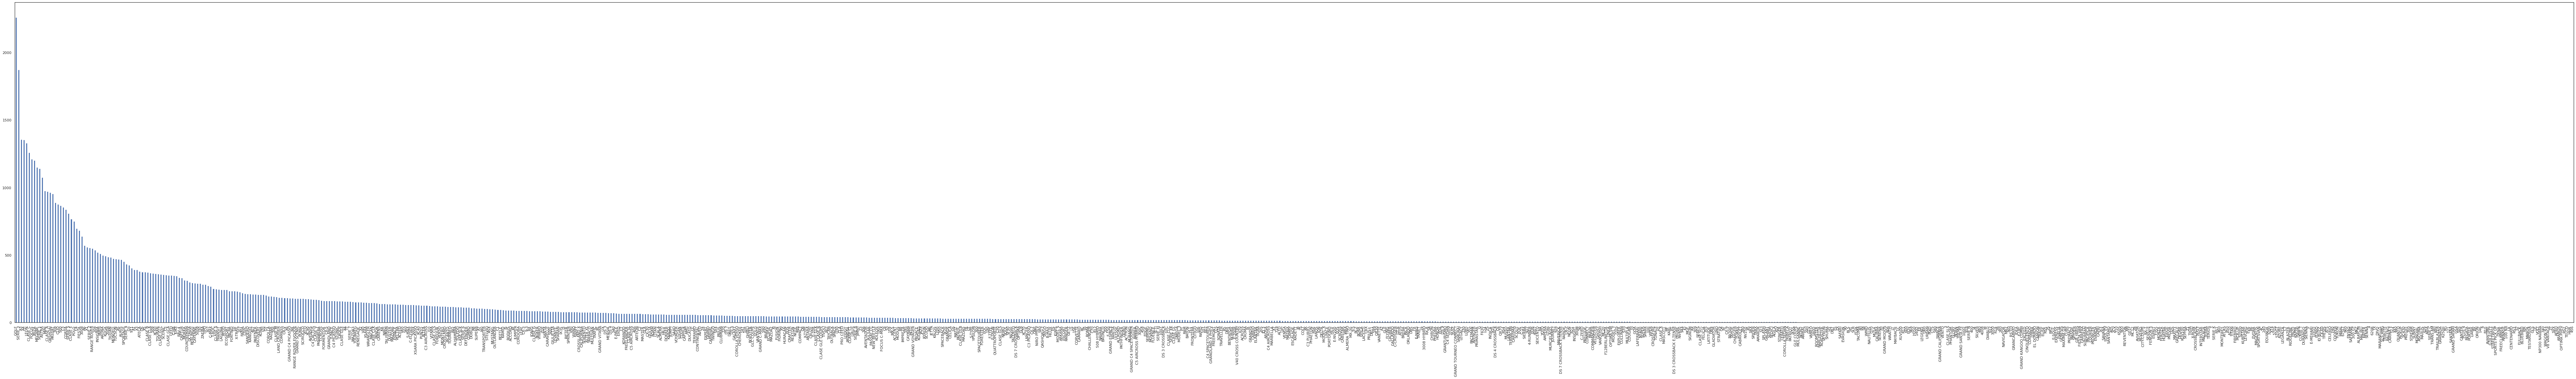

In [32]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(140, 18))
df_2mano['Modelo'].value_counts().plot.bar()

Podemos ver agrupado por marcas y modelos

In [33]:
fig = px.treemap(data_frame= df_2mano, path=["Marca","Modelo","Combustible"])
fig.show()

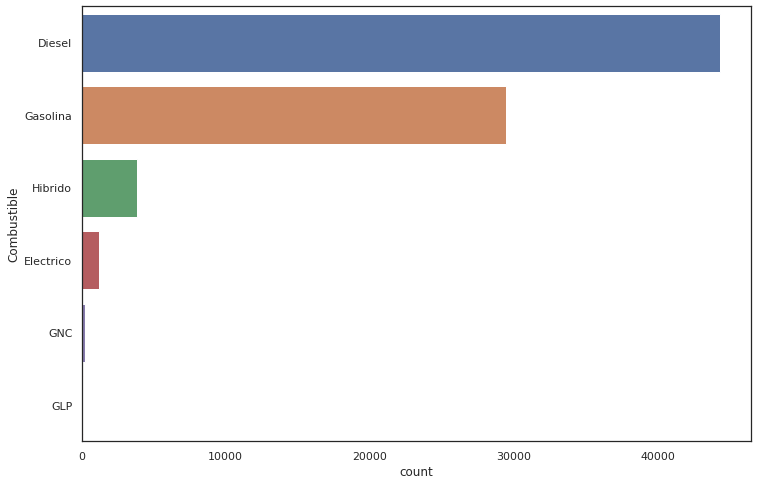

In [34]:
sns.set(style="white")
sns.countplot(y="Combustible", data=(df_2mano))

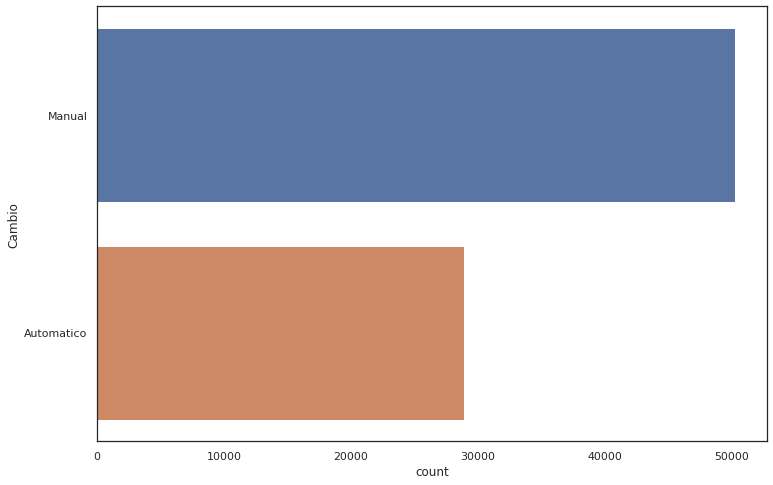

In [35]:
sns.set(style="white")
sns.countplot(y="Cambio", data=(df_2mano))

Vemos como queda el dataframe usando variables dummies (variables ficticias) para codificar las variables categóricas.

In [36]:
df_2mano_dummies = pd.get_dummies(df_2mano, sparse = True)

In [37]:
df_2mano_dummies.shape

(79107, 1127)

Al usar variables dummies, el número de características se vuelve muy grande. De ese modo, vamos a proceder a realizar el modelado en un principio con todas las características y, posteriormente, haciendo una reducción de características usando el FeatureSelectorpara ver si es posible hacer un ajuste razonable con menos variables

## Modelado para predicción del precio de vehículos usados

Hacemos el ajuste usando todas las variables del dataframe

### Preprocesado

Al tener variables numéricas y categóricas, hacemos un preprocesado en primer lugar

In [38]:
num_feat = ['Año', 'Kilometraje', 'Potencia', 'Fotos']
cat_feat = ['Marca', 'Modelo', 'Combustible', 'Cambio', 'Provincia']

feat = num_feat + cat_feat

target = 'Precio'

Separamos dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_2mano.drop(columns = target),
                                        df_2mano[target],
                                        test_size=0.25,
                                        random_state = 123
                                    )

print("Dimensiones del dataframe original",df_2mano.shape)
print("Dimensiones del dataframe sin variable objetivo para train", X_train.shape)
print("variable objetivo para train", y_train.shape)
print("Dimensiones del dataframe sin variable objetivo para test", X_test.shape)
print("variable objetivo para test", y_test.shape)

Dimensiones del dataframe original (79107, 10)
Dimensiones del dataframe sin variable objetivo para train (59330, 9)
variable objetivo para train (59330,)
Dimensiones del dataframe sin variable objetivo para test (19777, 9)
variable objetivo para test (19777,)


Se hace un reset de índices

In [40]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Creamos un transformer para estandarizar las variables numéricas y para hacer un one hot encoding en las categoricas

In [41]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),
    ('recode categorical', 
      preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse = False), 
      cat_feat)
    ])

### Creación del pipeline con los modelos

Creamos el pipeline que aplica la transformación y asigna el modelo a usar.
Realmente, para los modelos tipo árbol (dtr, rfr y gbr) no sería necesario estandarizar (pero tampoco pasa nada si se hace)

In [42]:
dtr = Pipeline(steps = [("prep", data_transformer), ('dtr', DecisionTreeRegressor())])
rfr = Pipeline(steps = [("prep", data_transformer), ('rfr', RandomForestRegressor())])
gbr = Pipeline(steps = [("prep", data_transformer), ('gbr', GradientBoostingRegressor())])
lr = Pipeline(steps=[("prep", data_transformer), ("lr",LinearRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge",Ridge())])
lasso = Pipeline(steps=[("prep", data_transformer), ("lasso",Lasso())])
knr = Pipeline(steps=[("prep", data_transformer), ("knr",KNeighborsRegressor())])
#svr = Pipeline(steps=[("prep", data_transformer), ("svr",SVR())]) No acaba nunca de coverger
lsvr= Pipeline(steps=[("prep", data_transformer), ("lsvr",LinearSVR())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp",MLPRegressor())])
xgr = Pipeline(steps=[("prep", data_transformer), ("xgr",XGBRegressor())])

### Búsqueda inicial de hiperparámetros: RandomSearch

Se utiliza inicialmente la técnica de RandomSearchCV, para buscar unos parámetros iniciales que luego se puedan afinar con GridSearchCV

In [43]:
# Arbol de decisión
grid_rs_dtr = {"dtr__max_depth": list(np.arange(2, 20, step = 2)) 
              }
# Random Forest
grid_rs_rfr = {"rfr__n_estimators": list(np.arange(10, 100, step = 10)), 
                     
                     "rfr__max_depth": list(np.arange(10, 50, step = 10)), 
                      
                     "rfr__max_features": ["sqrt", 3, 4] 
                     }
# Gradient Boosting
grid_rs_gbr = {"gbr__loss": ["squared_error"],
                          "gbr__learning_rate": list(np.arange(0.05, 1, step = 0.1)), 
                          
                          "gbr__n_estimators": list(np.arange(5, 30, step = 5)), 
                          
                          "gbr__max_depth": list(np.arange(15, 30, step = 5)), 
                          
                          "gbr__subsample": list(np.arange(0.5, 1, step = 0.1)), 
                          
                          "gbr__max_features": ["sqrt", 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 5, step = 0.2))}

# Lasso
grid_rs_lasso= {'lasso__alpha': list(np.arange(0.1, 5, step = 0.2))}

# KNeighbors
grid_rs_knr = {"knr__n_neighbors": list(np.arange(1, 15, step = 2)), 
                  "knr__weights": ["uniform","distance"]  
                  }

# Linear Suppport Vector Machine 
grid_rs_lsvr={"lsvr__tol":[0.001,0.0001], "lsvr__C": [0.1, 5.0, 50.0]}

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),           
                                        (30,),          
                                        (30,30)],
            
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.1], 
            
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.1, step = 0.01)) 
           }

# XGBRegressor

grid_rs_xgr = {'xgr__max_depth': list(np.arange(1, 10, step = 1)),
            'xgr__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
            'xgr__n_estimators': list(np.arange(50, 200, step = 20))
            }

In [44]:
rs_dtr = RandomizedSearchCV(dtr, 
                    grid_rs_dtr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_rfr = RandomizedSearchCV(rfr, 
                    grid_rs_rfr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbr = RandomizedSearchCV(gbr, 
                    grid_rs_gbr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_lasso = RandomizedSearchCV(lasso, 
                    grid_rs_lasso,
                    n_iter = 20, 
                    cv=3, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_knr = RandomizedSearchCV(knr, 
                    grid_rs_knr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 20,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)

rs_lsvr = RandomizedSearchCV(lsvr,
                    grid_rs_lsvr,
                    n_iter = 20,
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_xgr = RandomizedSearchCV(xgr, 
                    grid_rs_xgr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_lr = GridSearchCV(lr,
                    param_grid={},
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

Se incluye tambien la regresión lineal, teniendo en cuenta que no tiene hiperparámetros

In [45]:
all_rs_searchs = {"rs_dtr":rs_dtr,
                    "rs_rfr":rs_rfr,
                    "rs_gbr":rs_gbr,
                    "rs_ridge":rs_ridge,
                    "rs_lasso":rs_lasso,
                    "rs_knr":rs_knr,
                    "rs_lsvr": rs_lsvr,
                    "rs_mlp":rs_mlp,
                    "rs_xgr": rs_xgr,
                    "rs_lr": rs_lr
                    }

#### Entrenamiento de los modelos

In [46]:
for nombre, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Haciendo Random Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Random Search de rs_dtr...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 37.66904616355896 s
Haciendo Random Search de rs_rfr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 111.94343042373657 s
Haciendo Random Search de rs_gbr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 54.5964412689209 s
Haciendo Random Search de rs_ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 35.90195870399475 s
Haciendo Random Search de rs_lasso...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+13, tolerance: 5.402e+10

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 212.79721784591675 s
Haciendo Random Search de rs_knr...
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Tiempo de entrenamiento: 338.5020282268524 s
Haciendo Random Search de rs_lsvr...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 5.320127964019775 s
Haciendo Random Search de rs_mlp...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 2611.3436510562897 s
Haciendo Random Search de rs_xgr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[17:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 2787.234843492508 s
Haciendo Random Search de rs_lr...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tiempo de entrenamiento: 20.746634244918823 s


Se evaluan el desempeño de los modelos tras usar RandomSearch, obteniendo la mejor puntuación de cada modelo. Para eso, hacemos pares modelo-puntuación y lo ordenamos (haciendo uso de un dataframe)

#### Desempeño de los modelos

In [47]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", "Best score"]).sort_values(by="Best score", ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
8,rs_xgr,-4.615933e+03
7,rs_mlp,-5.268540e+03
5,rs_knr,-5.304437e+03
0,rs_dtr,-5.368707e+03
1,rs_rfr,-6.295628e+03
2,rs_gbr,-7.034809e+03
4,rs_lasso,-7.779151e+03
3,rs_ridge,-7.918062e+03
6,rs_lsvr,-9.265810e+03
9,rs_lr,-2.425396e+11


Seleccionamos los 5 mejores modelos, a los que le haremos un GridSearch para afinar más los hiperparámetros. Para eso, vemos los valores de los mejores hiperparámetros obtenidos y vamos creando las mallas (grid) donde afinar los valores

##### XGR

Vemos las métricas de error y lo bueno que es el ajuste con los hiperparámetros resultantes del RandomSearch

In [48]:
best_randomsearch = all_rs_searchs["rs_xgr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('xgr', XGBRegressor(learning_rate=0.3, max_depth=8, n_estimators=150))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                            

In [49]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 9318857391.112003
MAE: 5731.14469325842
RMSE: 96534.22911647455


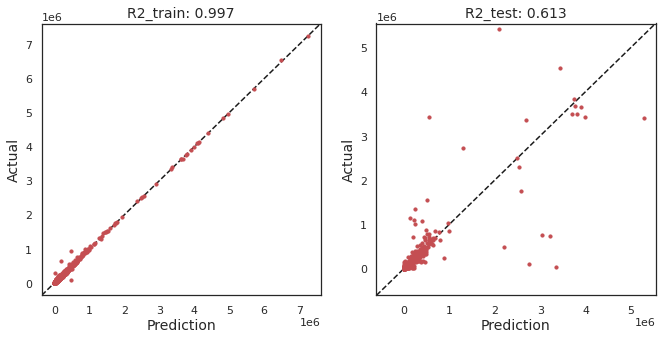

In [50]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_xgr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [51]:
grid_xgr = {'xgr__max_depth': [10, 11, 12],
            'xgr__learning_rate': [0.1, 0.15],
            'xgr__n_estimators': [150, 170, 190]
            }

##### MLP

También se procede igual

In [64]:
best_randomsearch = all_rs_searchs["rs_mlp"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('mlp',
   MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(30, 30),
                learning_rate_init=0.08099999999999999, max_iter=3000))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
      

In [65]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 6876688285.007955
MAE: 6094.979050540462
RMSE: 82925.79987559936


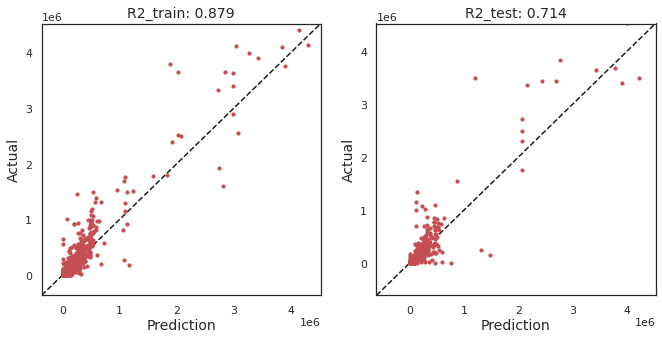

In [66]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_mlp)

In [67]:
grid_mlp = {"mlp__hidden_layer_sizes": [(34,), (34,34),
                                        (36,),(36,36),
                                        (38,),(38,38)],
           "mlp__activation": ["relu"], 
           "mlp__solver": ["adam"], 
           "mlp__alpha": [0.05, 0.075, 0.1, 0.125], 
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
           "mlp__learning_rate_init":list(np.arange(0.02, 0.1, step = 0.02)) 
           }

##### KNR

Repetimos el mismo procedimiento de antes

In [60]:
best_randomsearch = all_rs_searchs["rs_knr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('knr', KNeighborsRegressor(weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['Marca', 'Modelo

In [61]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 6640470063.003835
MAE: 5842.452833428845
RMSE: 81489.07940947569


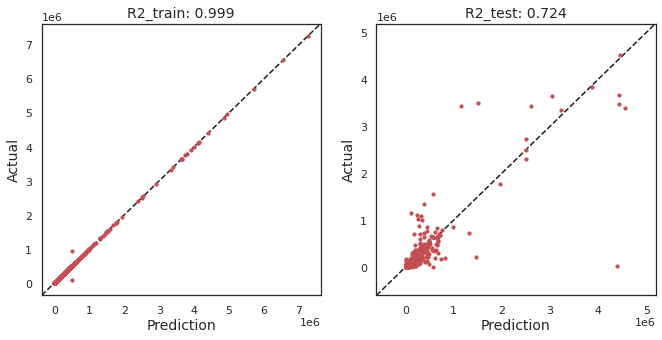

In [62]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_knr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [63]:
grid_knr = {"knr__n_neighbors": list(np.arange(7, 20, step = 1)), 
                  "knr__weights": ["uniform","distance"]  
                  }

##### DTR

Repetimos el mismo procedimiento de antes

In [56]:
best_randomsearch = all_rs_searchs["rs_dtr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('dtr', DecisionTreeRegressor(max_depth=18))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['Marca', 'Modelo', '

In [57]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 8695905260.938995
MAE: 5976.891051994785
RMSE: 93251.83784215192


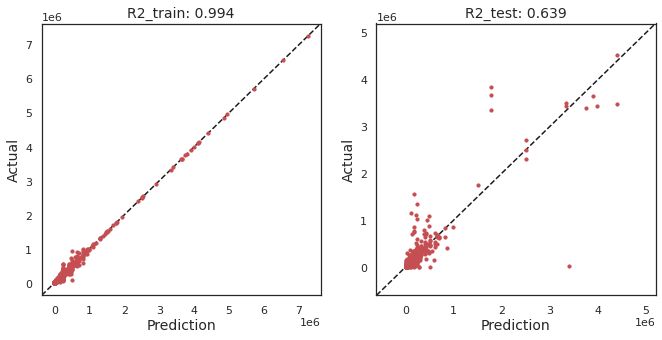

In [58]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_dtr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [59]:
grid_dtr = {"dtr__max_depth": list(np.arange(10, 30, step = 1)) 
              }

##### RFR

Repetimos el mismo procedimiento que con el XGR

In [52]:
best_randomsearch = all_rs_searchs["rs_rfr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('rfr',
   RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=40))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
              

In [53]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7625463990.079324
MAE: 7316.604800220953
RMSE: 87323.9027419144


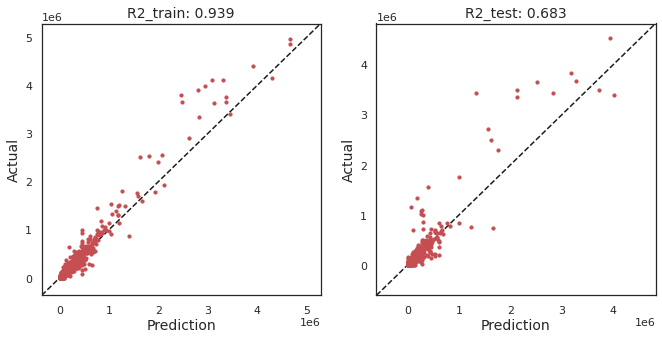

In [54]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_rfr)

In [55]:
grid_rfr = {"rfr__n_estimators": [110, 120, 130], 
            "rfr__max_depth": [90, 100, 110], 
            "rfr__max_features": ["sqrt", 3] 
                     }

### Finetuning de hiperparámetros

Para los 5 mejores modelos, en base a los resultados del RandomSearchCV, se hace un GridSearchCV con el objetivo de afinar los valores de los hiperparámetros

In [68]:
gs_xgr = GridSearchCV(xgr, 
                    grid_xgr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_rfr = GridSearchCV(rfr, 
                    grid_rfr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_dtr = GridSearchCV(dtr, 
                    grid_dtr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_knr = GridSearchCV(knr, 
                    grid_knr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_mlp = GridSearchCV(mlp,
                      grid_mlp,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)


In [69]:
all_gs_searchs = {"gs_xgr": gs_xgr,
                  "gs_rfr": gs_rfr,
                  "gs_dtr": gs_dtr,
                  "gs_knr": gs_knr,
                    "gs_mlp": gs_mlp
                    }

#### Entrenamiento de los modelos

In [70]:
for nombre, grid_search in all_gs_searchs.items():
    start = time.time()
    print("Haciendo Grid Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Grid Search de gs_xgr...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[18:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 6433.768270015717 s
Haciendo Grid Search de gs_rfr...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tiempo de entrenamiento: 643.8975658416748 s
Haciendo Grid Search de gs_dtr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 83.22622513771057 s
Haciendo Grid Search de gs_knr...
Fitting 5 folds for each of 26 candidates, totalling 130 fits
Tiempo de entrenamiento: 618.2122623920441 s
Haciendo Grid Search de gs_mlp...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Tiempo de entrenamiento: 6145.945820808411 s


#### Desempeño de los modelos

Evaluamos las métricas con el conjunto de test

##### XGR

In [71]:
best_randomsearch = all_gs_searchs["gs_xgr"]
best_pipeline = best_randomsearch.best_estimator_

In [72]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('xgr', XGBRegressor(learning_rate=0.15, max_depth=12, n_estimators=190))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                          

In [73]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 9361878830.732811
MAE: 5566.062221923865
RMSE: 96756.80250366281


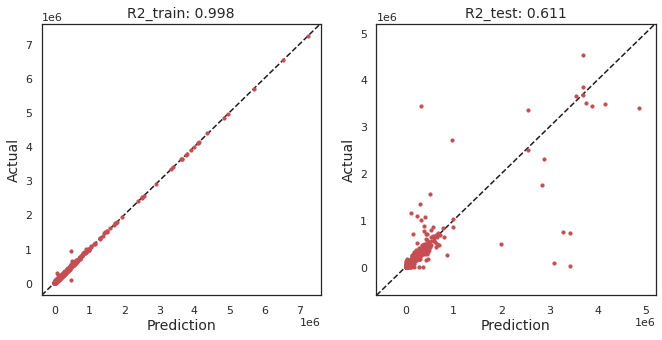

In [74]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_xgr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



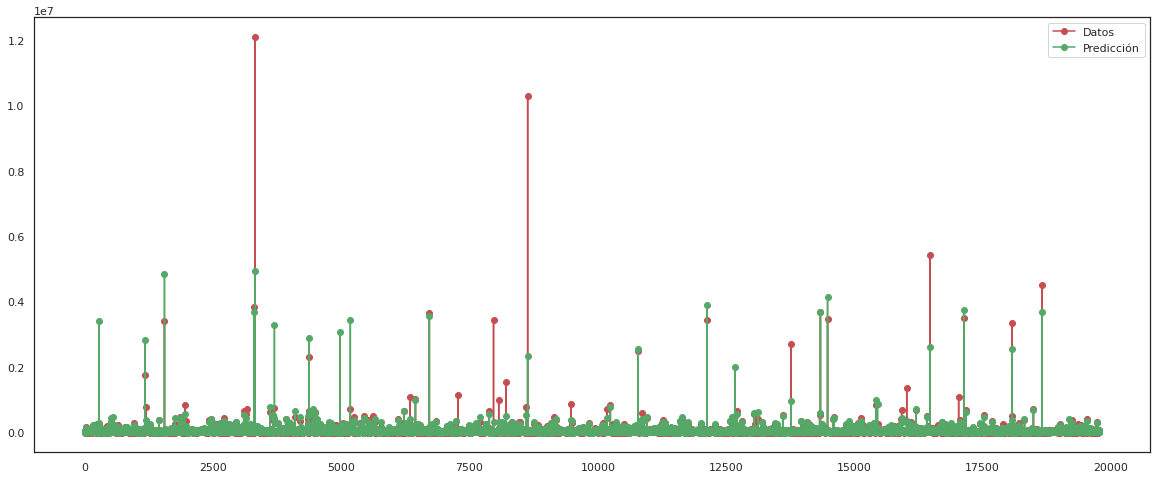

In [75]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### MLP

In [91]:
best_randomsearch = all_gs_searchs["gs_mlp"]
best_pipeline = best_randomsearch.best_estimator_

In [92]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('mlp',
   MLPRegressor(alpha=0.075, early_stopping=True, hidden_layer_sizes=(36, 36),
                learning_rate_init=0.04, max_iter=3000))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                   

In [93]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 5695001875.995861
MAE: 6106.276055282047
RMSE: 75465.23620844143


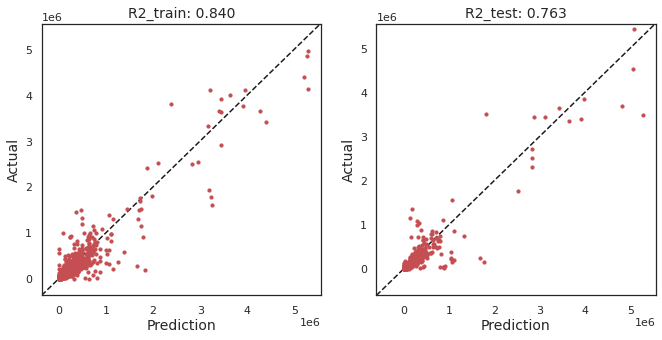

In [94]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_mlp)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



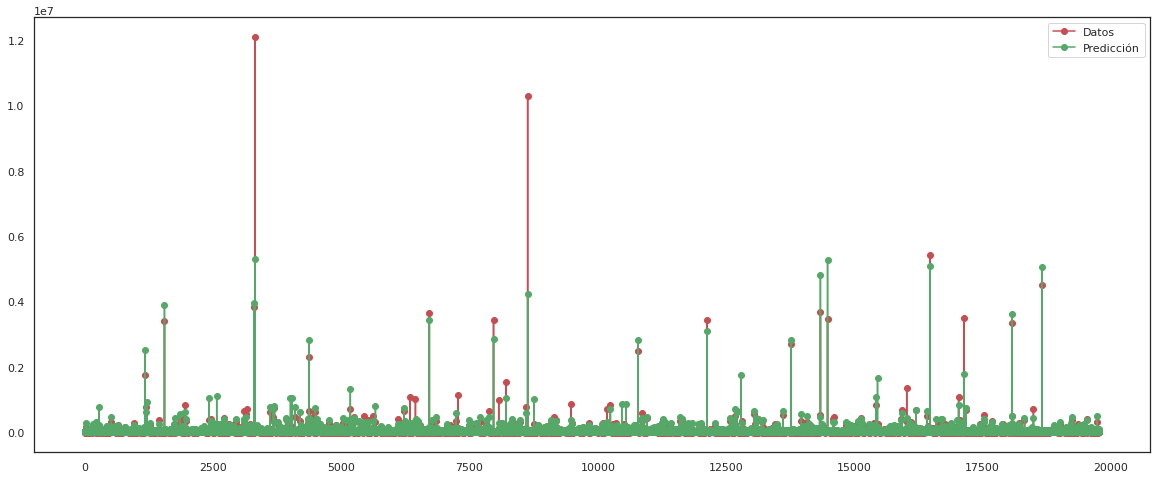

In [95]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

El tiempo de ejecucción es muy alto. ¿Esto justifica reducir las características que aporten información?

##### KNR

In [86]:
best_randomsearch = all_gs_searchs["gs_knr"]
best_pipeline = best_randomsearch.best_estimator_

In [87]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('knr', KNeighborsRegressor(n_neighbors=8, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['

In [88]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 6708181628.6832
MAE: 5818.153472318448
RMSE: 81903.48972225298


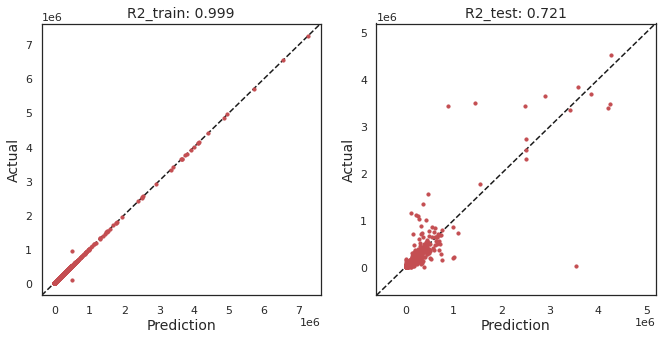

In [89]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_knr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



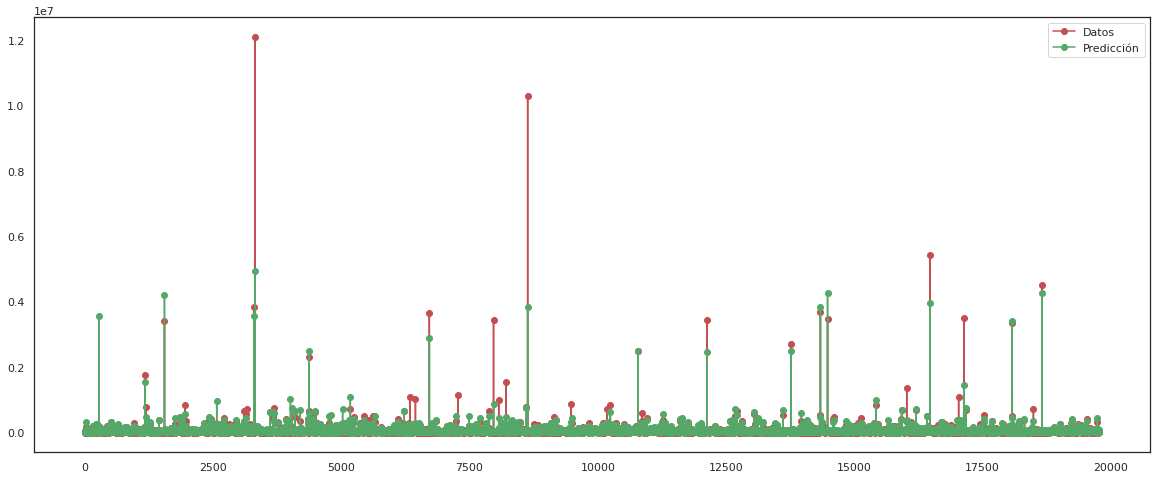

In [90]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### DTR

In [81]:
best_randomsearch = all_gs_searchs["gs_dtr"]
best_pipeline = best_randomsearch.best_estimator_

In [82]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('dtr', DecisionTreeRegressor(max_depth=24))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['Marca', 'Modelo', '

In [83]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 8346220478.836336
MAE: 5870.865408656972
RMSE: 91357.6514520614


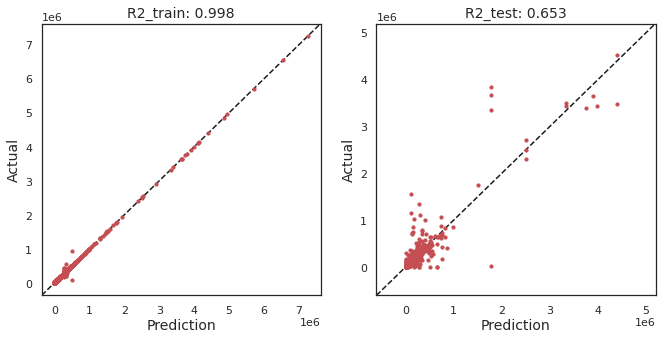

In [84]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_dtr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



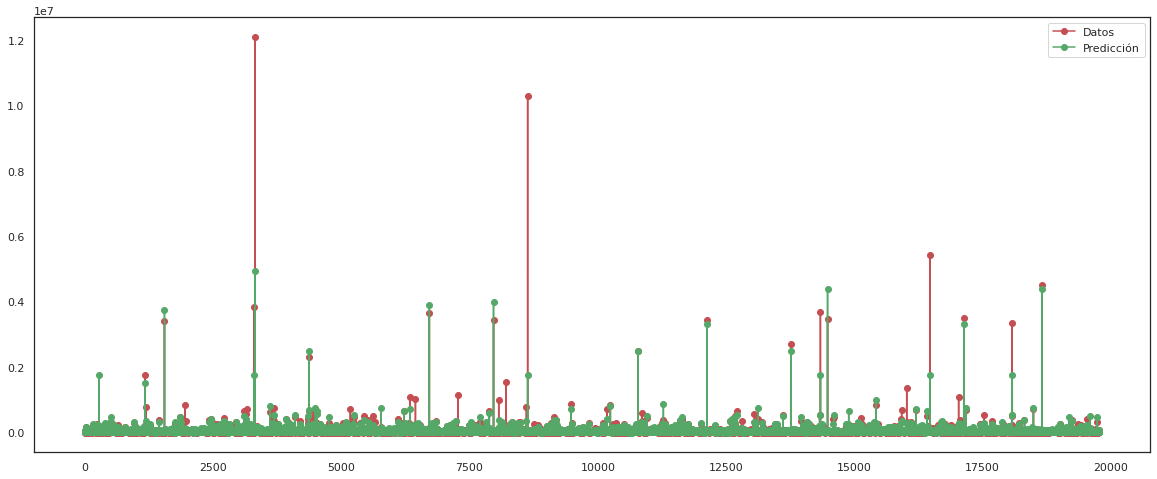

In [85]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### RFR

In [76]:
best_randomsearch = all_gs_searchs["gs_rfr"]
best_pipeline = best_randomsearch.best_estimator_

In [77]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('rfr',
   RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=130))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
            

In [78]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7411353385.04336
MAE: 5270.971838384628
RMSE: 86089.21758875126


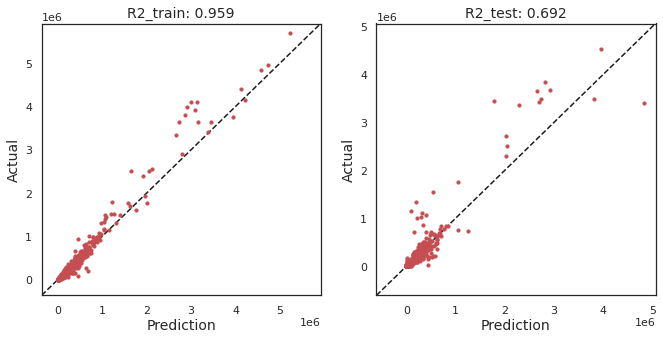

In [79]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_rfr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



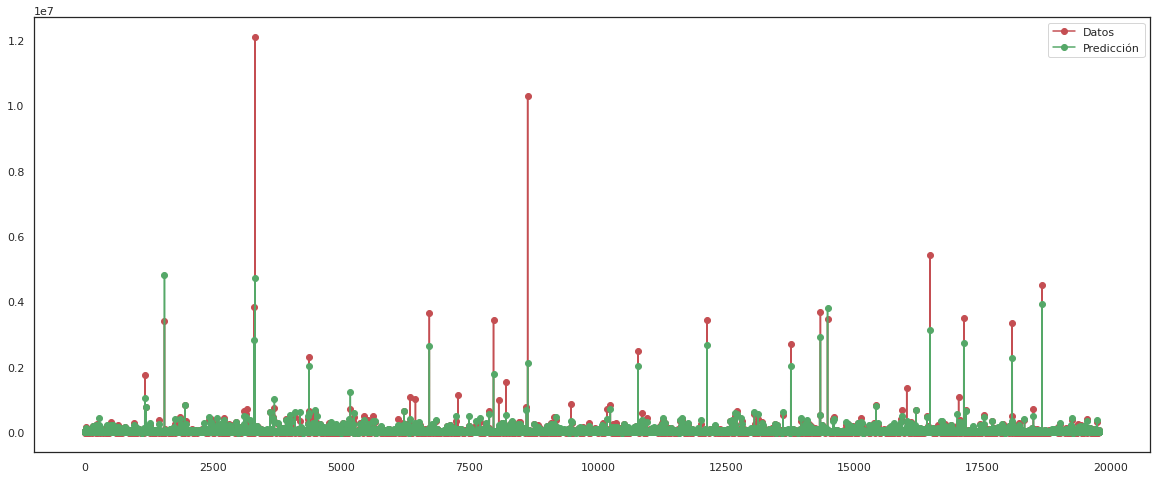

In [80]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

## Modelado de predicción de precio usando FeatureSelect para usar sólo las características más importantes


Vamos a comprobar si es posible obtener buenos resultados en la predicción eliminando las características que tienen poca importancia.

Antes de hacer uso de FeatureSelector es necesario hacer la división entre train/test, para usar la selección de características en el conjunto de entrenamiento

No es preciso hace one hot enconding, ya que lo hace el propio método

### Preprocesado

Ya tenemos previamente separados el dataframe en dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

Cargamos FeatureSelector

In [96]:
fs = FeatureSelector(data = X_train , labels = y_train)

In [97]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'l2', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	valid_0's l2: 4.47838e+09	valid_0's l2: 4.47838e+09
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[195]	valid_0's l2: 4.78962e+09	valid_0's l2: 4.78962e+09
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 6.39567e+09	valid_0's l2: 6.39567e+09
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	valid_0's l2: 1.02928e+09	valid_0's l2: 1.02928e+09
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[433]	valid_0's l2: 7.90177e+08	valid_0's l2: 7.90177e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	valid_0's l2: 6.53036e+09	valid_0's l2: 6.53036e+09
Training until val

El número de variables con importancia cero cambia ligeramente en función del número de iteraciones (es un proceso con una cierta estocasticidad)

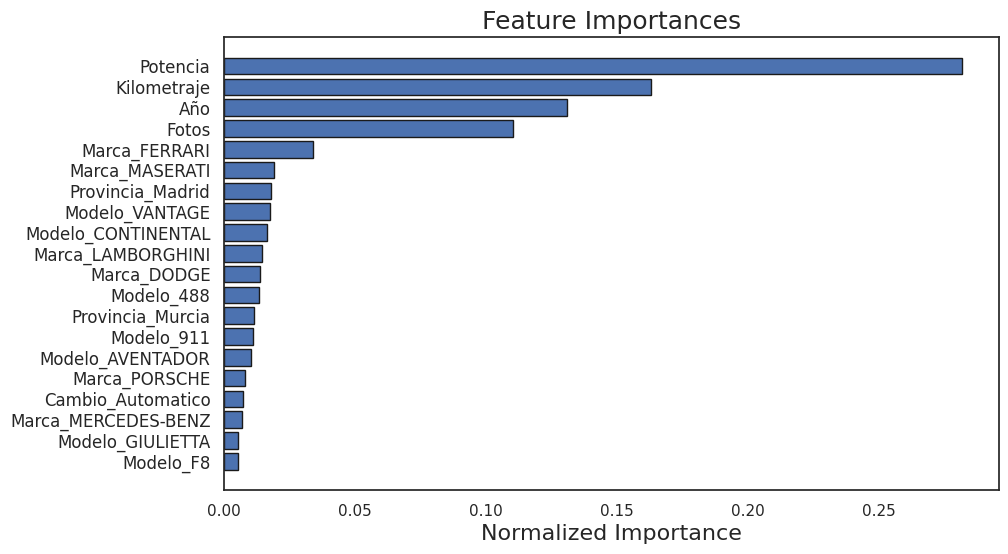

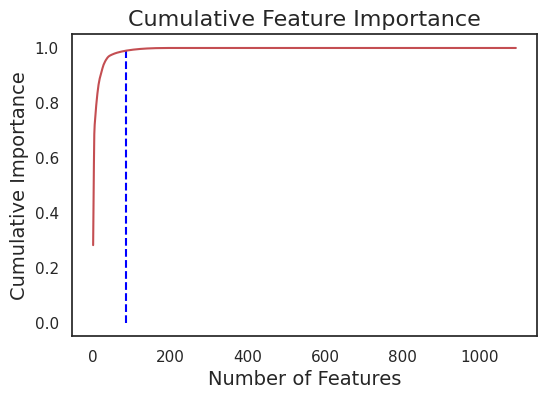

86 features required for 0.99 of cumulative importance


In [98]:
sns.set(style="white")
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)

In [99]:
fs.feature_importances.head(30)

,feature,importance,normalized_importance,cumulative_importance
0,Potencia,1929.0,0.281894,0.281894
1,Kilometraje,1116.1,0.163101,0.444995
2,Año,896.0,0.130937,0.575932
3,Fotos,755.6,0.110419,0.686351
4,Marca_FERRARI,232.4,0.033962,0.720313
5,Marca_MASERATI,130.5,0.019071,0.739383
6,Provincia_Madrid,123.0,0.017975,0.757358
7,Modelo_VANTAGE,119.8,0.017507,0.774865
8,Modelo_CONTINENTAL,112.8,0.016484,0.791349
9,Marca_LAMBORGHINI,100.5,0.014687,0.806035


Se observa que la característica más importante es la potencia del vehículo, seguido del kilometraje. El número de fotos es la variable numérica menos relevante.

También es posible ver las características que tienen poca relevancia (destacar que este método también es estocástico)

In [100]:
fs.identify_low_importance(cumulative_importance = 0.99)

85 features required for cumulative importance of 0.99 after one hot encoding.
1008 features do not contribute to cumulative importance of 0.99.



Es decir, que entre todas las caracaterísticas, entorno a 965 (según el método que se seleccione), se puede cubrir el 99% de la importancia acumulada.

Vemos las variables con poca importancia

In [101]:
low_importance_features = fs.ops['low_importance']
print("Total de características con poca importancia:", len(low_importance_features))
print(low_importance_features[:965])

Total de características con poca importancia: 1008
['Modelo_SERIE 1', 'Modelo_Z3', 'Modelo_MONDEO', 'Provincia_Palmas (Las)', 'Modelo_GLC COUPÉ', 'Marca_SKODA', 'Marca_RENAULT', 'Modelo_V90', 'Modelo_508', 'Marca_FIAT', 'Modelo_X2', 'Marca_LEXUS', 'Modelo_XC60', 'Modelo_MÉGANE', 'Modelo_CLASE A', 'Modelo_CLASE B', 'Modelo_SERIE 3', 'Provincia_Asturias', 'Modelo_I30', 'Modelo_CITAN', 'Modelo_TOUAREG', 'Modelo_JIMNY', 'Marca_CUPRA', 'Marca_SSANGYONG', 'Marca_TOYOTA', 'Modelo_XC40', 'Modelo_A6', 'Cambio_Manual', 'Marca_DS', 'Modelo_QASHQAI', 'Modelo_CLASE SL', 'Marca_SEAT', 'Marca_DACIA', 'Modelo_CX-3', 'Modelo_TAYCAN', 'Modelo_X1', 'Modelo_TUCSON', 'Modelo_SERIE 2', 'Modelo_AURIS', 'Marca_ALFA ROMEO', 'Provincia_Málaga', 'Modelo_Q2', 'Marca_SUBARU', 'Modelo_X3', 'Modelo_COROLLA', 'Modelo_300', 'Modelo_PASSAT', 'Modelo_INSIGNIA', 'Marca_HYUNDAI', 'Provincia_Albacete', 'Modelo_TERRANO', 'Modelo_SF90', 'Modelo_NX', 'Modelo_Z4', 'Marca_PEUGEOT', 'Modelo_5008', 'Modelo_ARTEON', 'Modelo_C-ELY

Vemos también si hay variables con muy alta correlación, por si fuera necesario eliminarlas

In [102]:
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'regression', 'eval_metric': 'l2', 
                                     'cumulative_importance': 0.99})

0 features with greater than 0.60 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[586]	valid_0's l2: 2.15518e+09	valid_0's l2: 2.15518e+09
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 2.8373e+09	valid_0's l2: 2.8373e+09
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[536]	valid_0's l2: 2.4346e+09	valid_0's l2: 2.4346e+09
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[334]	valid_0's l2: 1.81939e+09	valid_0's l2: 1.81939e+09
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 2.47944e+09	valid_0's l2: 2.47944e+09
Training unt

Vemos que no hay variables con missing values ni correlacionadas.
Vamos a generar ahora un datraframe en le que se eliminen las variables que tienen poca o ninguna importancia

In [103]:
df_2mano_fs = fs.remove(methods = 'all', keep_one_hot = True)

['zero_importance', 'low_importance', 'missing', 'single_unique', 'collinear'] methods have been run

Removed 986 features.


Podemos ver la reducción de características que se ha realizado al usar FeatureSelect

In [104]:
print( "Dataframe original con one hot encoding", df_2mano_dummies.shape)
print( "Dataframe modificado con FeatureSelect", df_2mano_fs.shape)

Dataframe original con one hot encoding (79107, 1127)
Dataframe modificado con FeatureSelect (59330, 112)


Se observa que se ha pasado de 1127 características a 121

Mostramos las características que finalmente hemos dejado

In [105]:
lista = list(df_2mano_fs.columns)
lista.insert(0, 'Precio')
originales = ['Marca', 'Modelo', 'Combustible', 'Cambio', 'Provincia']
lista = [e for e in lista if e not in originales]
print(lista)

['Precio', 'Marca_ASTON MARTIN', 'Marca_AUDI', 'Marca_BENTLEY', 'Marca_BMW', 'Marca_CADILLAC', 'Marca_CHEVROLET', 'Marca_CITROEN', 'Marca_DACIA', 'Marca_DODGE', 'Marca_FERRARI', 'Marca_FIAT', 'Marca_FORD', 'Marca_LAMBORGHINI', 'Marca_LAND-ROVER', 'Marca_LEXUS', 'Marca_MASERATI', 'Marca_MERCEDES-BENZ', 'Marca_MINI', 'Marca_OPEL', 'Marca_PORSCHE', 'Marca_RENAULT', 'Marca_SEAT', 'Marca_SKODA', 'Marca_SSANGYONG', 'Marca_TESLA', 'Marca_TOYOTA', 'Marca_VOLKSWAGEN', 'Modelo_3008', 'Modelo_308', 'Modelo_488', 'Modelo_508', 'Modelo_911', 'Modelo_AMG', 'Modelo_AURIS', 'Modelo_AVENTADOR', 'Modelo_CALIFORNIA', 'Modelo_CARAVELLE', 'Modelo_CITAN', 'Modelo_CLASE A', 'Modelo_CLASE C', 'Modelo_CLASE G', 'Modelo_CLASE GLC', 'Modelo_CLASE GLE', 'Modelo_CLASE GLE COUPÉ', 'Modelo_CLASE S', 'Modelo_CLASE V', 'Modelo_CONTINENTAL', 'Modelo_DEFENDER', 'Modelo_E-PACE', 'Modelo_E-TRON', 'Modelo_F-PACE', 'Modelo_F8', 'Modelo_FOCUS', 'Modelo_GHIBLI', 'Modelo_GIULIETTA', 'Modelo_GLC COUPÉ', 'Modelo_HURACÁN', 'Model

Modificamos el dataframe original para quedarnos sólo con las columnas que tienen importancia y la variable objetivo

In [106]:
df_2mano_dummies = df_2mano_dummies[lista]

Exportamos el dataframe para tener una copia

In [107]:
df_2mano_dummies.to_excel(path+"df_2mano_dummies.xlsx", header=True)

In [108]:
#df_2mano_dummies = pd.read_excel(path+'df_2mano_dummies.xlsx', index_col=[0])
#Para poder trabajar en local

Separamos dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_2mano_dummies.drop(columns = target),
                                        df_2mano_dummies[target],
                                        test_size=0.25,
                                        random_state = 123
                                    )

print("Dimensiones del dataframe original",df_2mano_dummies.shape)
print("Dimensiones del dataframe sin variable objetivo para train", X_train.shape)
print("variable objetivo para train", y_train.shape)
print("Dimensiones del dataframe sin variable objetivo para test", X_test.shape)
print("variable objetivo para test", y_test.shape)

Dimensiones del dataframe original (79107, 108)
Dimensiones del dataframe sin variable objetivo para train (59330, 107)
variable objetivo para train (59330,)
Dimensiones del dataframe sin variable objetivo para test (19777, 107)
variable objetivo para test (19777,)


Se hace un reset de índices

In [110]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Creamos un transformer para estandarizar las variables numéricas (ya no hay variables categoricas al haber hecho el one hot enconding previamente para el dataframe df_2mano_dummies)

In [111]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),    
    ])

### Creación del pipeline con los modelos

Creamos el pipeline que aplica la transformación y asigna el modelo a usar.
Realmente, para los modelos tipo árbol (dtr, rfr y gbr) no sería necesario estandarizar (pero tampoco pasa nada si se hace)

In [112]:
dtr = Pipeline(steps = [("prep", data_transformer), ('dtr', DecisionTreeRegressor())])
rfr = Pipeline(steps = [("prep", data_transformer), ('rfr', RandomForestRegressor())])
gbr = Pipeline(steps = [("prep", data_transformer), ('gbr', GradientBoostingRegressor())])
lr = Pipeline(steps=[("prep", data_transformer), ("lr",LinearRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge",Ridge())])
lasso = Pipeline(steps=[("prep", data_transformer), ("lasso",Lasso())])
knr = Pipeline(steps=[("prep", data_transformer), ("knr",KNeighborsRegressor())])
#svr = Pipeline(steps=[("prep", data_transformer), ("svr",SVR())]) No acaba nunca de coverger
lsvr= Pipeline(steps=[("prep", data_transformer), ("lsvr",LinearSVR())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp",MLPRegressor())])
xgr = Pipeline(steps=[("prep", data_transformer), ("xgr",XGBRegressor())])

### Búsqueda inicial de hiperparámetros: RandomSearch

Se utiliza inicialmente la técnica de RandomSearchCV, para buscar unos parámetros iniciales que luego se puedan afinar con GridSearchCV

In [113]:
# Arbol de decisión
grid_rs_dtr = {"dtr__max_depth": list(np.arange(2, 20, step = 2)) 
              }
# Random Forest
grid_rs_rfr = {"rfr__n_estimators": list(np.arange(10, 100, step = 10)), 
                     
                     "rfr__max_depth": list(np.arange(10, 50, step = 10)), 
                      
                     "rfr__max_features": ["sqrt", 3, 4] 
                     }
# Gradient Boosting
grid_rs_gbr = {"gbr__loss": ["squared_error"],
                          "gbr__learning_rate": list(np.arange(0.05, 1, step = 0.1)), 
                          
                          "gbr__n_estimators": list(np.arange(5, 30, step = 5)), 
                          
                          "gbr__max_depth": list(np.arange(15, 30, step = 5)), 
                          
                          "gbr__subsample": list(np.arange(0.5, 1, step = 0.1)), 
                          
                          "gbr__max_features": ["sqrt", 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 5, step = 0.2))}

# Lasso
grid_rs_lasso= {'lasso__alpha': list(np.arange(0.1, 5, step = 0.2))}

# KNeighbors
grid_rs_knr = {"knr__n_neighbors": list(np.arange(1, 15, step = 2)), 
                  "knr__weights": ["uniform","distance"]  
                  }

# Linear Suppport Vector Machine 
grid_rs_lsvr={"lsvr__tol":[0.001,0.0001], "lsvr__C": [0.1, 5.0, 50.0]}

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),           
                                        (30,),          
                                        (30,30)],
            
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.1], 
            
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.1, step = 0.01)) 
           }

# XGBRegressor

grid_rs_xgr = {'xgr__max_depth': list(np.arange(1, 10, step = 1)),
            'xgr__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
            'xgr__n_estimators': list(np.arange(50, 200, step = 20))
            }

In [114]:
rs_dtr = RandomizedSearchCV(dtr, 
                    grid_rs_dtr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_rfr = RandomizedSearchCV(rfr, 
                    grid_rs_rfr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbr = RandomizedSearchCV(gbr, 
                    grid_rs_gbr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_lasso = RandomizedSearchCV(lasso, 
                    grid_rs_lasso,
                    n_iter = 20, 
                    cv=3, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_knr = RandomizedSearchCV(knr, 
                    grid_rs_knr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 20,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)

rs_lsvr = RandomizedSearchCV(lsvr,
                    grid_rs_lsvr,
                    n_iter = 20,
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_xgr = RandomizedSearchCV(xgr, 
                    grid_rs_xgr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_lr = GridSearchCV(lr,
                    param_grid={},
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

Se incluye tambien la regresión lineal, teniendo en cuenta que no tiene hiperparámetros

In [115]:
all_rs_searchs = {"rs_dtr":rs_dtr,
                    "rs_rfr":rs_rfr,
                    "rs_gbr":rs_gbr,
                    "rs_ridge":rs_ridge,
                    "rs_lasso":rs_lasso,
                    "rs_knr":rs_knr,
                    "rs_lsvr": rs_lsvr,
                    "rs_mlp":rs_mlp,
                    "rs_xgr": rs_xgr,
                    "rs_lr": rs_lr
                    }

#### Entrenamiento de los modelos

Se procede a entrenar los modelos para el RandomSearch previsto

In [116]:
for nombre, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Haciendo Random Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Random Search de rs_dtr...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 4.47147011756897 s
Haciendo Random Search de rs_rfr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 61.99264574050903 s
Haciendo Random Search de rs_gbr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/usr/local/lib/python3.8/dist-packages

Tiempo de entrenamiento: 21.919559478759766 s
Haciendo Random Search de rs_ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 3.9958441257476807 s
Haciendo Random Search de rs_lasso...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tiempo de entrenamiento: 2.4715447425842285 s
Haciendo Random Search de rs_knr...
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 4.203562021255493 s
Haciendo Random Search de rs_lsvr...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 1.3909575939178467 s
Haciendo Random Search de rs_mlp...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 488.66334414482117 s
Haciendo Random Search de rs_xgr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[21:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 42.55880355834961 s
Haciendo Random Search de rs_lr...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tiempo de entrenamiento: 0.6159589290618896 s


Se evaluan el desempeño de los modelos tras usar RandomSearch, obteniendo la mejor puntuación de cada modelo. Para eso, hacemos pares modelo-puntuación y lo ordenamos (haciendo uso de un dataframe)

#### Desempeño de los modelos

In [117]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", "Best score"]).sort_values(by="Best score", ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
1,rs_rfr,-6487.933817
8,rs_xgr,-6785.500588
5,rs_knr,-6953.127359
2,rs_gbr,-6982.865638
0,rs_dtr,-7129.679443
7,rs_mlp,-8285.010648
6,rs_lsvr,-10052.225621
9,rs_lr,-18924.489288
3,rs_ridge,-18924.542481
4,rs_lasso,-18928.141987


Seleccionamos los 5 mejores modelos, a los que le haremos un GridSearch para afinar más los hiperparámetros. Para eso, vemos los valores de los mejores hiperparámetros obtenidos y vamos creando las mallas (grid) donde afinar los valores

##### RFR

Repetimos el mismo procedimiento que con el XGR

In [118]:
best_randomsearch = all_rs_searchs["rs_rfr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('rfr',
   RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=70))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'rfr': RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=70),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__w

In [119]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 8819375065.671465
MAE: 7225.175095706182
RMSE: 93911.52786357734


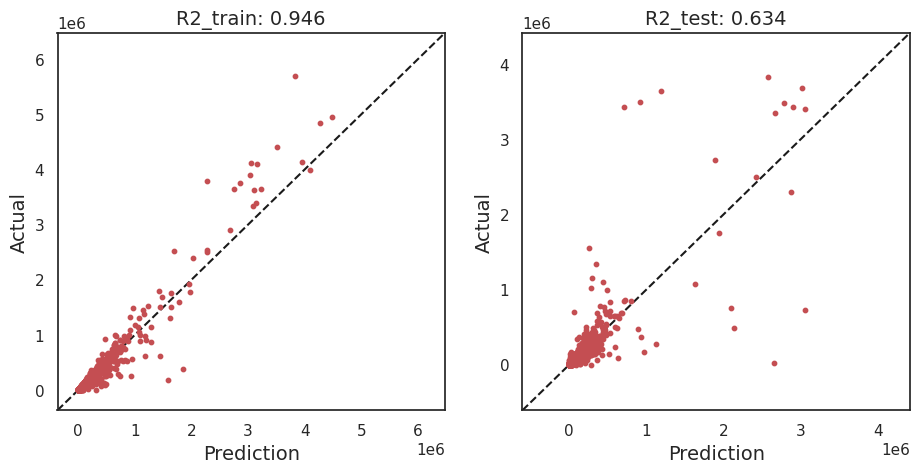

In [120]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_rfr)

In [121]:
grid_rfr = {"rfr__n_estimators": [70, 75, 80, 85, 90], 
            "rfr__max_depth": [40, 45, 50, 55, 60], 
            "rfr__max_features": ["sqrt", 3] 
                     }

##### XGR

Vemos las métricas de error y lo bueno que es el ajuste con los hiperparámetros resultantes del RandomSearch

In [122]:
best_randomsearch = all_rs_searchs["rs_xgr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('xgr', XGBRegressor(max_depth=8, n_estimators=90))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'xgr': XGBRegressor(max_depth=8, n_estimators=90),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'xgr__base_score': 0.5,
 'xgr__booster': 'gbtree

In [123]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 9397249937.06925
MAE: 7704.014827231591
RMSE: 96939.4137442003


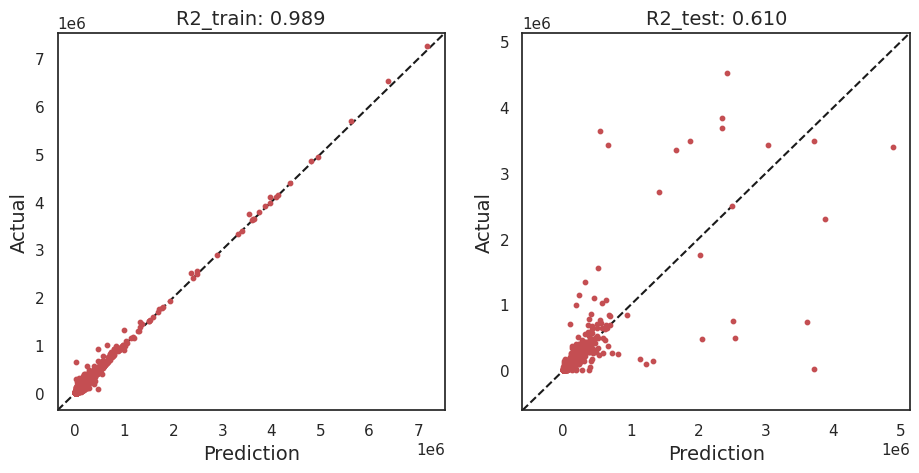

In [124]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_xgr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [125]:
grid_xgr = {'xgr__max_depth': [5, 6, 7, 8, 9],
            'xgr__learning_rate': [0.15, 0.2, 0.25],
            'xgr__n_estimators': [250, 270, 290, 310, 330, 350, 370]
            }

##### KNR

Repetimos el mismo procedimiento de antes

In [134]:
best_randomsearch = all_rs_searchs["rs_knr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('knr', KNeighborsRegressor(n_neighbors=13, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'knr': KNeighborsRegressor(n_neighbors=13, weights='distance'),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'knr__algorithm': 'aut

In [135]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7323092983.83496
MAE: 7445.504773908429
RMSE: 85575.0722105156


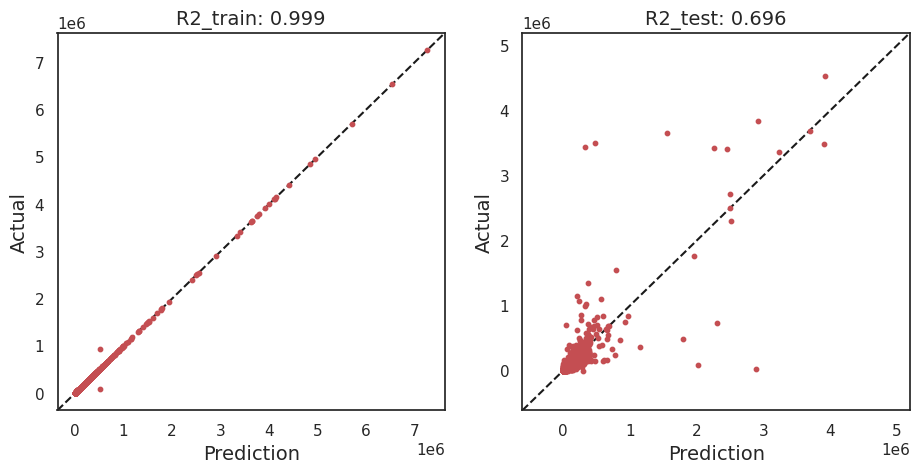

In [136]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_knr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [137]:
grid_knr = {"knr__n_neighbors": list(np.arange(5, 20, step = 1)), 
                  "knr__weights": ["uniform","distance"]  
                  }

##### GBR

Repetimos el mismo procedimiento de antes

In [126]:
best_randomsearch = all_rs_searchs["rs_gbr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('gbr',
   GradientBoostingRegressor(learning_rate=0.25000000000000006, max_depth=20,
                             max_features='sqrt', n_estimators=25,
                             subsample=0.7999999999999999))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'gbr': GradientBoostingRegressor(learning_rate=0.25000000000000006, max_depth=20,
                           max_features='sqrt', n_estimators=25,
                           subsample=0.7999999999999999),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilome

In [127]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7463499127.370521
MAE: 7535.880041525421
RMSE: 86391.54546233399


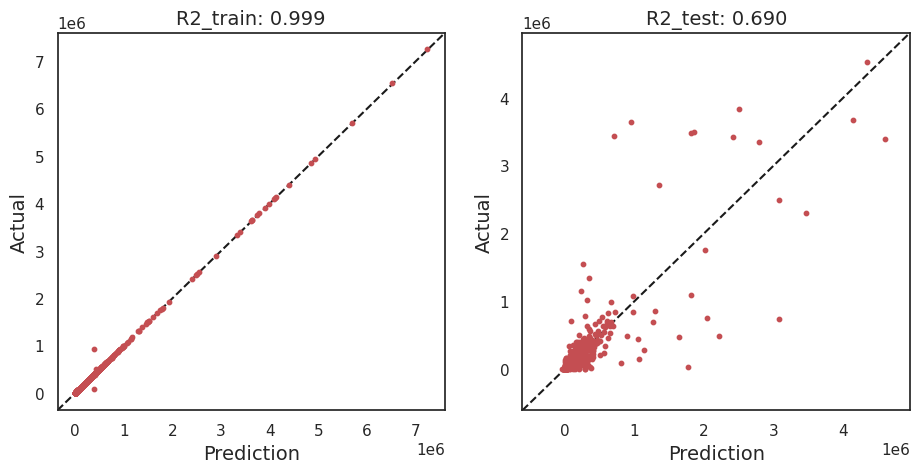

In [128]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_gbr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [129]:
grid_gbr = {"gbr__loss": ["squared_error"],
                "gbr__learning_rate": [0.10, 0.15, 0.2],           
                "gbr__n_estimators": [25, 35, 45], 
                "gbr__max_depth": [11, 12, 13], 
                "gbr__subsample": [0.85, 0.9, 0.95], 
                "gbr__max_features": ['sqrt', 2], 
                }

##### DTR

También se procede igual

In [130]:
best_randomsearch = all_rs_searchs["rs_dtr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('dtr', DecisionTreeRegressor(max_depth=12))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'dtr': DecisionTreeRegressor(max_depth=12),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'dtr__ccp_alpha': 0.0,
 'dtr__criterion': 'squared_error',
 'd

In [131]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 9227750812.587538
MAE: 7832.943485836695
RMSE: 96061.18265245092


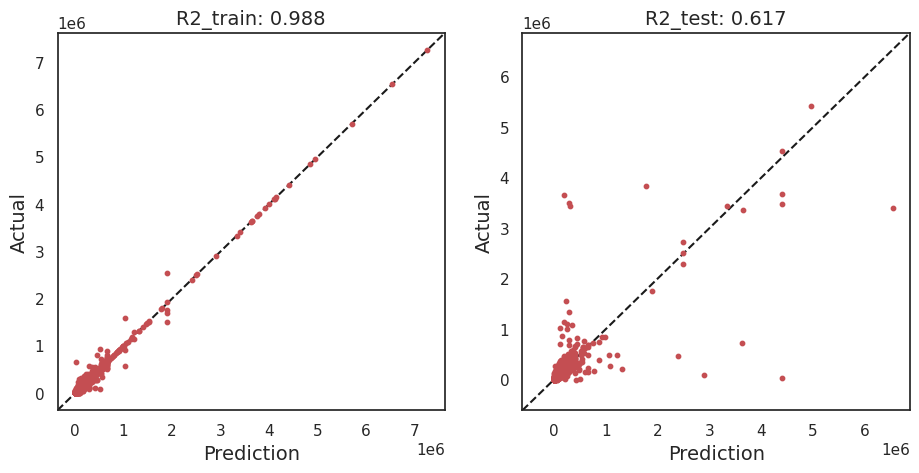

In [132]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_dtr)

In [133]:
grid_dtr = {"dtr__max_depth": list(np.arange(2, 20, step = 1))
           }

### Finetuning de hiperparámetros

Para los 5 mejores modelos, en base a los resultados del RandomSearchCV, se hace un GridSearchCV con el objetivo de afinar los valores de los hiperparámetros

In [138]:
gs_xgr = GridSearchCV(xgr, 
                    grid_xgr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_rfr = GridSearchCV(rfr, 
                    grid_rfr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_gbr = GridSearchCV(gbr, 
                    grid_gbr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_knr = GridSearchCV(knr, 
                    grid_knr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_dtr = GridSearchCV(dtr,
                      grid_dtr,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)


In [139]:
all_gs_searchs = {"gs_xgr": gs_xgr,
                  "gs_rfr": gs_rfr,
                  "gs_gbr": gs_gbr,
                  "gs_knr": gs_knr,
                    "gs_dtr": gs_dtr
                    }

#### Entrenamiento de los modelos

In [140]:
for nombre, grid_search in all_gs_searchs.items():
    start = time.time()
    print("Haciendo Grid Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Grid Search de gs_xgr...
Fitting 5 folds for each of 105 candidates, totalling 525 fits
[21:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 669.042986869812 s
Haciendo Grid Search de gs_rfr...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Tiempo de entrenamiento: 241.09434056282043 s
Haciendo Grid Search de gs_gbr...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Tiempo de entrenamiento: 248.6094651222229 s
Haciendo Grid Search de gs_knr...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Tiempo de entrenamiento: 9.57059359550476 s
Haciendo Grid Search de gs_dtr...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tiempo de entrenamiento: 4.8657402992248535 s


#### Desempeño de los modelos

Evaluamos las métricas con el conjunto de test

##### RFR

In [141]:
best_randomsearch = all_gs_searchs["gs_rfr"]
best_pipeline = best_randomsearch.best_estimator_

In [142]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('rfr',
   RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=90))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'rfr': RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=90),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__w

In [143]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 8285480336.493253
MAE: 7186.108040388151
RMSE: 91024.61390466455


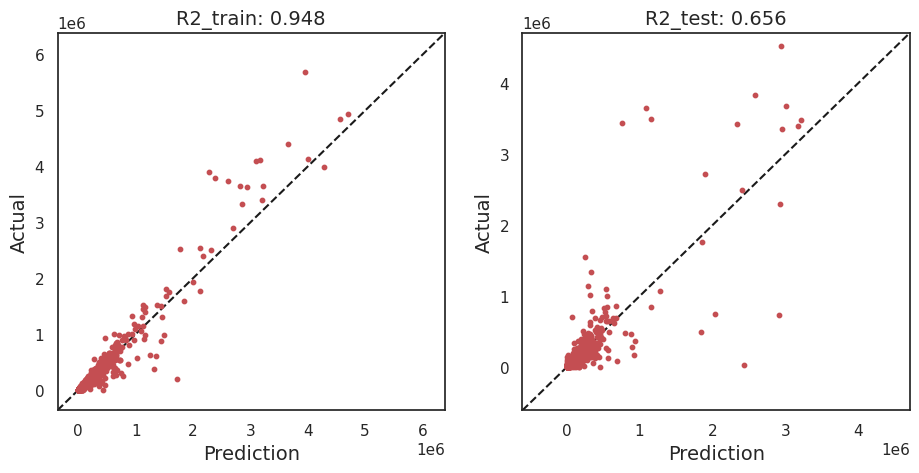

In [144]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_rfr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



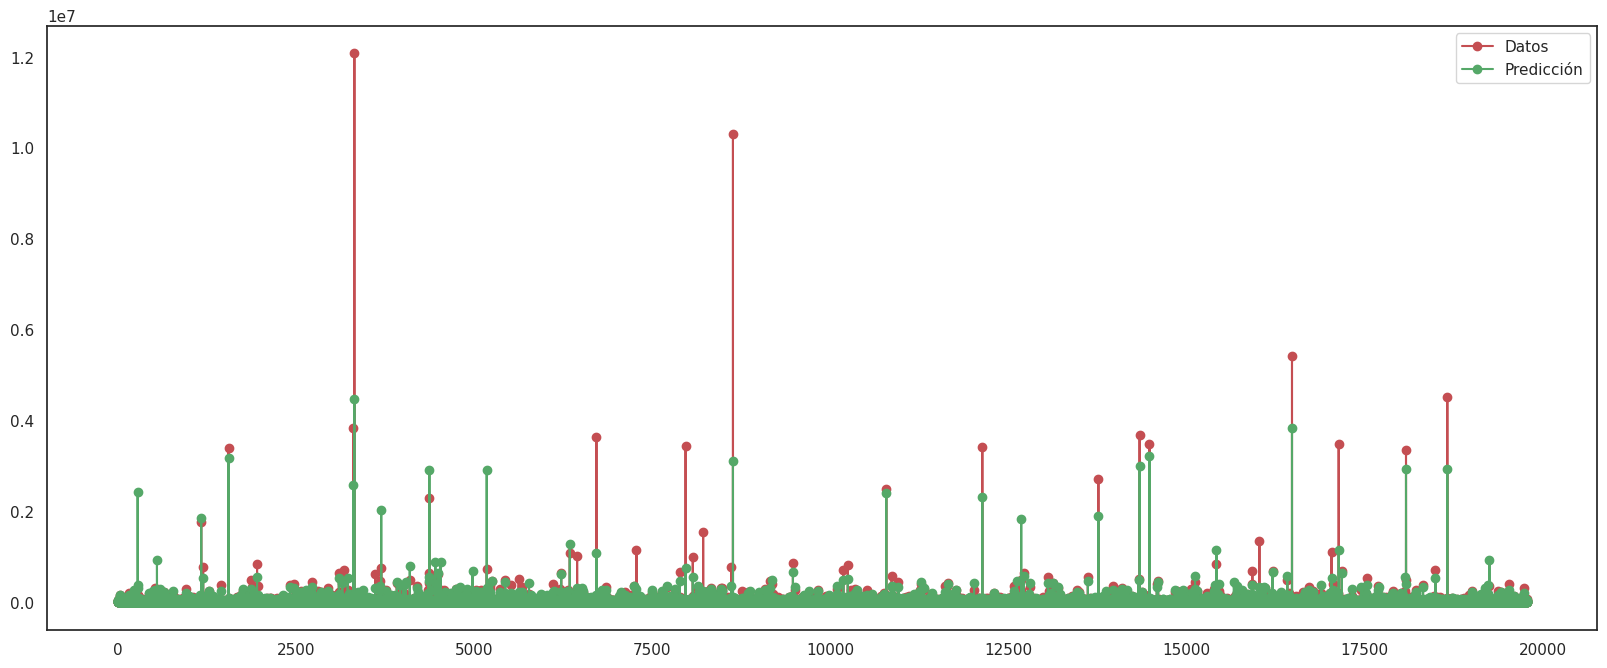

In [145]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### XGR

In [146]:
best_randomsearch = all_gs_searchs["gs_xgr"]
best_pipeline = best_randomsearch.best_estimator_

In [147]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('xgr', XGBRegressor(learning_rate=0.25, max_depth=7, n_estimators=250))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'xgr': XGBRegressor(learning_rate=0.25, max_depth=7, n_estimators=250),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'xgr__

In [148]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 8826169558.580746
MAE: 7210.018983446588
RMSE: 93947.69586626776


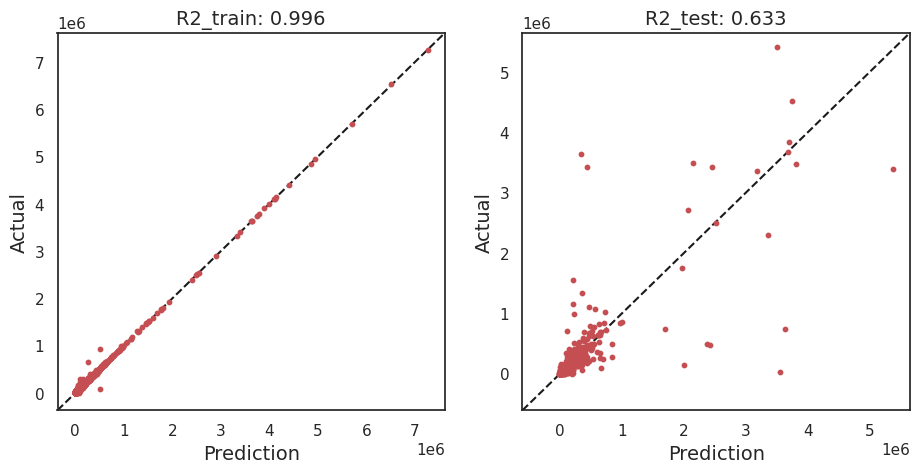

In [149]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_xgr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



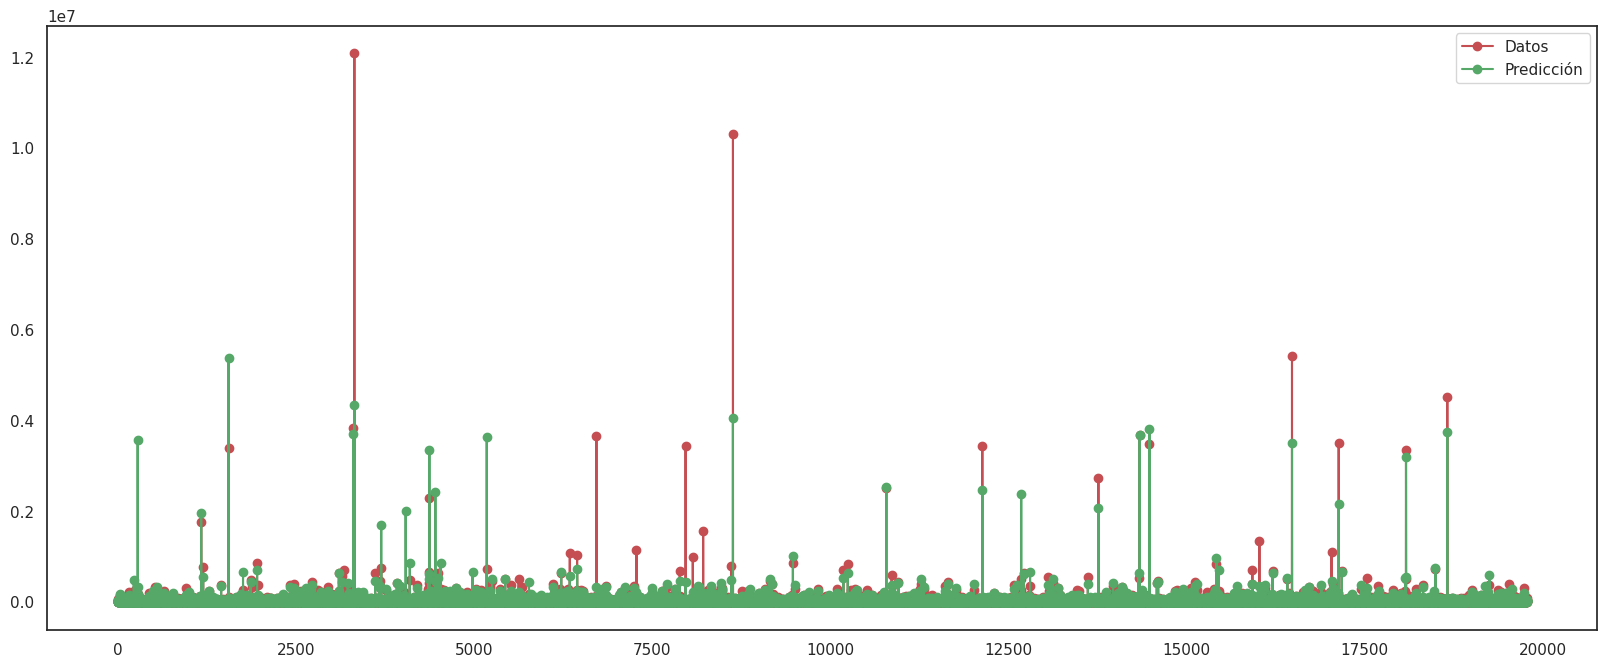

In [150]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### KBR

In [161]:
best_randomsearch = all_gs_searchs["gs_knr"]
best_pipeline = best_randomsearch.best_estimator_

In [162]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('knr', KNeighborsRegressor(n_neighbors=19, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'knr': KNeighborsRegressor(n_neighbors=19, weights='distance'),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'knr__algorithm': 'aut

In [163]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7376883630.585426
MAE: 7480.534425396513
RMSE: 85888.78640768786


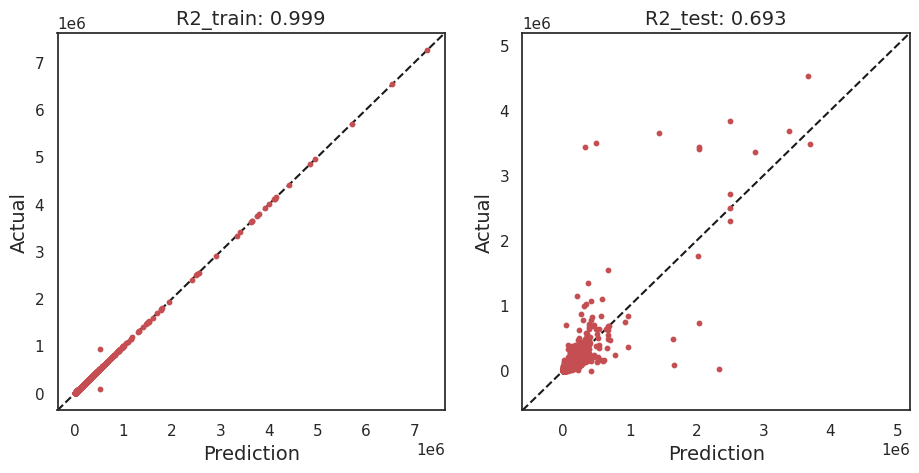

In [164]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_knr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



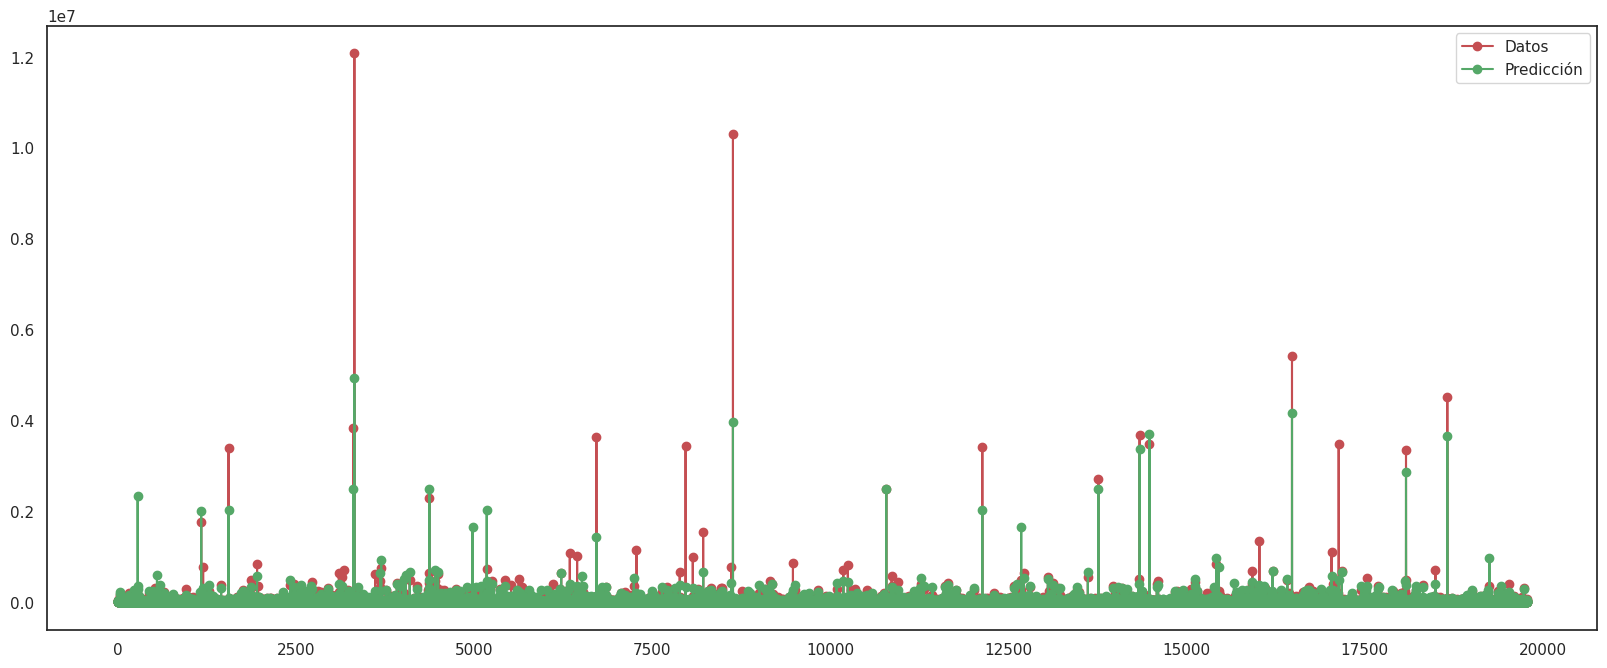

In [165]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### GBR

In [151]:
best_randomsearch = all_gs_searchs["gs_gbr"]
best_pipeline = best_randomsearch.best_estimator_

In [152]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('gbr',
   GradientBoostingRegressor(max_depth=13, max_features='sqrt', n_estimators=35,
                             subsample=0.9))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'gbr': GradientBoostingRegressor(max_depth=13, max_features='sqrt', n_estimators=35,
                           subsample=0.9),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__resca

In [153]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 7785920983.570169
MAE: 7001.4929701091005
RMSE: 88237.86592824063


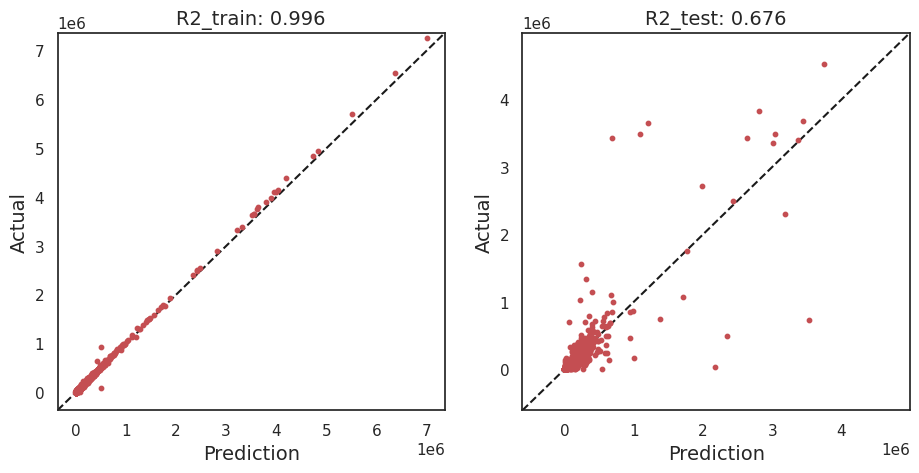

In [154]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_gbr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



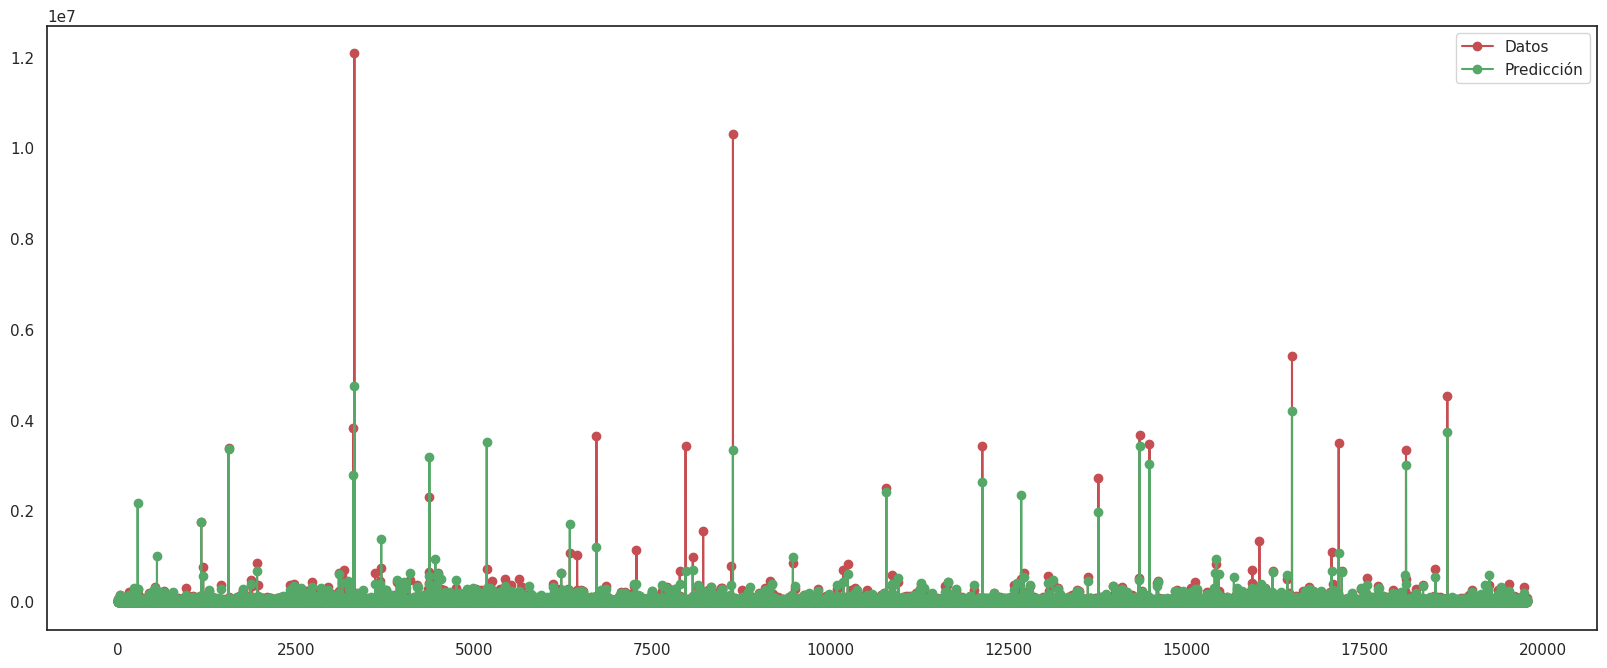

In [155]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### DTR

In [156]:
best_randomsearch = all_gs_searchs["gs_dtr"]
best_pipeline = best_randomsearch.best_estimator_

In [157]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos'])])),
  ('dtr', DecisionTreeRegressor(max_depth=14))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos'])]),
 'dtr': DecisionTreeRegressor(max_depth=14),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__copy': True,
 'prep__rescale numeric__with_mean': True,
 'prep__rescale numeric__with_std': True,
 'dtr__ccp_alpha': 0.0,
 'dtr__criterion': 'squared_error',
 'd

In [158]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 9203486974.929613
MAE: 7948.14643511801
RMSE: 95934.80585756982


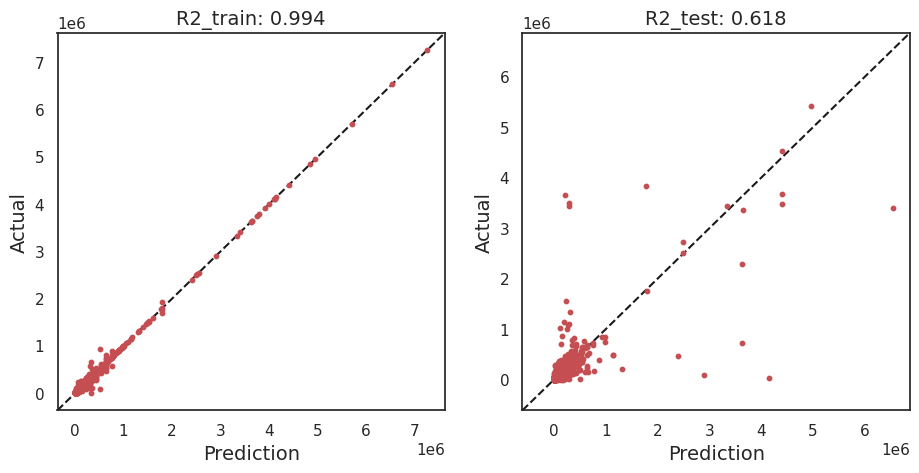

In [159]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_dtr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



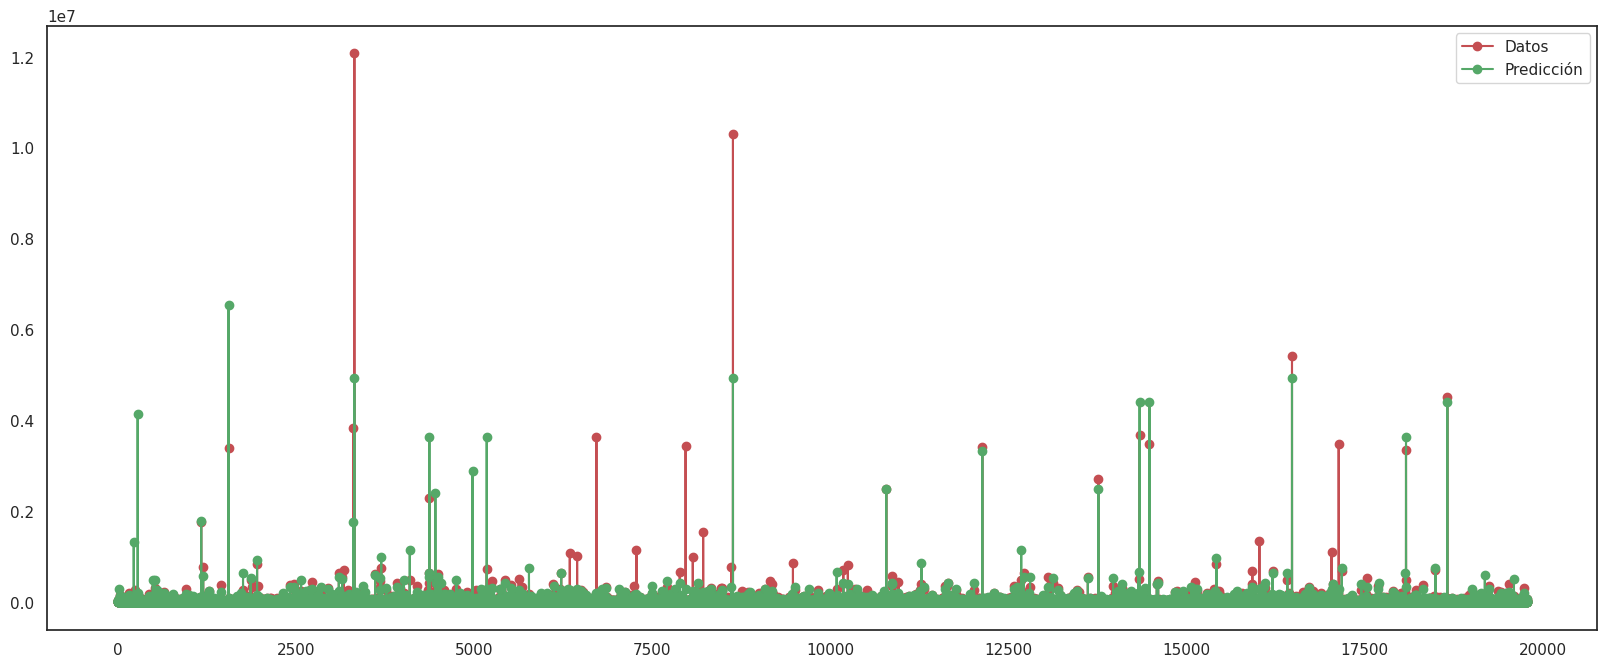

In [160]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()